The aim of this notebook is to develop a unique player performance index, splitting by player's position n the court and considering a different set of variables dependeding on this position. 

All stats have been aggregated by player (regardless of the team, season and country where he played) to come up with the methodology to create the index. When implemented, the performance index will be able to calculate by season or team.

## Imports

In [5]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import joblib

from sklearn import decomposition
from sklearn import cluster
import umap
from sklearn.metrics import silhouette_score, silhouette_samples, precision_recall_fscore_support
import pingouin as pg
from factor_analyzer import FactorAnalyzer
import statsmodels.api as sm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

path='C:/Repo/MiM_Analytics_Tesis/Tesis/'
#path='C:/Users/E0662122/Repo/MiM_Analytics_Tesis/Tesis/'

C:\Users\fabri\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
postgreSQL = {"host": "localhost", "port": "5432", "username": "postgres", 
               "password": "trivisono", "database": "SportsAnalytics"}

uri = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
postgreSQL['username'], postgreSQL['password'], postgreSQL['host'], postgreSQL['port'], postgreSQL['database'])

engine = create_engine(uri)
conn = engine.raw_connection()
cursor = conn.cursor()

In [3]:
df_perf_index = pd.read_sql_query("SELECT * FROM fdm.dash_ft_abt_all_seasons;", conn)
df_all = pd.read_sql_query("SELECT * FROM fdm.dash_ft_abt;", conn)

rating_correction = pd.read_sql_query("SELECT player_id, \
    SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) wavg_player_rating \
    FROM fdm.ft_api_matches_stats_players AS stats_players GROUP BY player_id \
    HAVING SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) IS NOT NULL", conn)

In [43]:
df_perf_index = pd.read_csv(path+'AR_20211019.csv', sep='|', decimal='.')
rating_correction = pd.read_csv(path+'rating_correction.csv', sep='|', decimal='.')

In [4]:
df_all.to_csv(path+'AR_All_20211026.csv', sep='|', decimal='.')

## Preprocessing

### Filtering and Variable Creation

In [4]:
df = df[(df['player_minutes']>=270) & (df['player_id']>0)].copy()

In [5]:
df['tackles_total_padj'] = np.where(df['tackles_total_padj'].isna(), df['tackles_total'], df['tackles_total_padj'])
df['tackles_blocks_padj'] = np.where(df['tackles_blocks_padj'].isna(), df['tackles_blocks'], df['tackles_blocks_padj'])
df['tackles_interceptions_padj'] = np.where(df['tackles_interceptions_padj'].isna(), df['tackles_interceptions'], df['tackles_interceptions_padj'])
df['dribbles_past_padj'] = np.where(df['dribbles_past_padj'].isna(), df['dribbles_past'], df['dribbles_past_padj'])
df['fouls_committed_padj'] = np.where(df['fouls_committed_padj'].isna(), df['fouls_committed'], df['fouls_committed_padj'])

In [6]:
# Attacking
df['offsides_p90'] = df['offsides']/df['player_minutes']*90
df['shots_p90'] = df['shots_total']/df['player_minutes']*90
df['shooting_accuracy'] = np.where(df['shots_total']==0, 0, 
                                   np.where(df['shots_total']<df['shots_on_goal'], 1,
                                            df['shots_on_goal']/df['shots_total']))
df['goals_p90'] = df['goals_total']/df['player_minutes']*90
df['np_goals_p90'] = np.where(df['goals_total']-df['penalty_scored']<0, 0, (df['goals_total']-df['penalty_scored'])/df['player_minutes']*90)
df['goal_conversion'] = np.where(df['shots_total']==0, 0, df['goals_total']/df['shots_total'])
df['goal_conversion_np'] = np.where(df['shots_total']==0, 0, (df['goals_total']-df['penalty_scored'])/df['shots_total'])
df['assists_p90'] = df['goals_assists']/df['player_minutes']*90
df['penalty_won_p90'] = df['penalty_won']/df['player_minutes']*90
df['penalty_missed_p90'] = df['penalty_missed']/df['player_minutes']*90
# Build-up
df['passes_p90'] = df['passes_total']/df['player_minutes']*90
df['passing_accuracy'] = np.where(df['passes_total']==0, 0, df['passes_completed']/df['passes_total'])
df['key_passes_p90'] = df['passes_key']/df['player_minutes']*90
df['fouls_drawn_p90'] = df['fouls_drawn']/df['player_minutes']*90
# Defense
df['tackles_p90'] = np.where(df['tackles_total_padj'].isna(), df['tackles_total'], df['tackles_total_padj'])/df['player_minutes']*90
df['blocks_p90'] = np.where(df['tackles_blocks_padj'], df['tackles_blocks'], df['tackles_blocks_padj'])/df['player_minutes']*90
df['interceptions_p90'] = np.where(df['tackles_interceptions_padj'].isna(), df['tackles_interceptions'], df['tackles_interceptions_padj'])/df['player_minutes']*90
df['total_tackles_p90'] = df['tackles_p90']+df['blocks_p90']+df['interceptions_p90']
df['saves_p90'] = df['goals_saves']/df['player_minutes']*90
df['penalty_saves_p90'] = df['penalty_saved']/df['player_minutes']*90
df['penalty_committed_p90'] = df['penalty_committed']/df['player_minutes']*90
df['goals_conceded_p90'] = df['goals_conceded']/df['player_minutes']*90
df['fouls_committed_p90'] = np.where(df['fouls_committed_padj'].isna(), df['fouls_committed'], df['fouls_committed_padj'])/df['player_minutes']*90
# One vs one
df['duels_p90'] = df['duels_total']/df['player_minutes']*90
df['duels_success_ratio'] = np.where(df['duels_total']==0, 0, df['duels_won']/df['duels_total'])
df['dribbles_p90'] = df['dribbles_attemps']/df['player_minutes']*90
df['dribbles_success_ratio'] = np.where(df['dribbles_attemps']==0, 0, df['dribbles_success']/df['dribbles_attemps'])
df['dribbles_past_p90'] = np.where(df['dribbles_past_padj'], df['dribbles_past'], df['dribbles_past_padj'])/df['player_minutes']*90
# General
df['cards_yellow_p90'] = df['cards_yellow']/df['player_minutes']*90
df['cards_red_p90'] = df['cards_red']/df['player_minutes']*90
# Combined
df['scoring_contribution'] = df['np_goals_p90']+df['assists_p90']

In [7]:
df.columns

Index(['Unnamed: 0', 'player_id', 'player_name', 'player_preferred_position',
       'player_preferred_number', 'player_minutes', 'offsides', 'shots_total',
       'shots_on_goal', 'goals_total', 'goals_conceded', 'goals_assists',
       'goals_saves', 'passes_total', 'passes_key', 'passes_completed',
       'tackles_total', 'tackles_blocks', 'tackles_interceptions',
       'tackles_total_padj', 'tackles_blocks_padj',
       'tackles_interceptions_padj', 'duels_total', 'duels_won',
       'dribbles_attemps', 'dribbles_success', 'dribbles_past',
       'dribbles_past_padj', 'fouls_drawn', 'fouls_committed',
       'fouls_committed_padj', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_committed', 'penalty_scored', 'penalty_missed',
       'penalty_saved', 'offsides_p90', 'shots_p90', 'shooting_accuracy',
       'goals_p90', 'np_goals_p90', 'goal_conversion', 'goal_conversion_np',
       'assists_p90', 'penalty_won_p90', 'penalty_missed_p90', 'passes_p90',
       'passing_acc

In [8]:
# Fill NAs rating with ratings from the same players in other seasons
df = df.merge(rating_correction, on=['player_id'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating_x'].isna(), df['wavg_player_rating_y'], df['wavg_player_rating_x'])
del df['wavg_player_rating_x'], df['wavg_player_rating_y']

# Fill NAs rating with average rating of the position in the entire dataset
df_ratings_pos = df[['player_preferred_position', 'wavg_player_rating']].groupby(['player_preferred_position']).median().rename(
    columns={'wavg_player_rating': 'wavg_position_rating'}).reset_index()
df = df.merge(df_ratings_pos, on=['player_preferred_position'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating'].isna(), df['wavg_position_rating'], df['wavg_player_rating'])
del df['wavg_position_rating']

In [9]:
df['player_preferred_position'].value_counts()

M    4330
D    3802
F    2266
G     873
-       8
Name: player_preferred_position, dtype: int64

In [10]:
df.head()

,Unnamed: 0_x,player_id,player_name,player_preferred_position,player_preferred_number,player_minutes,offsides,shots_total,shots_on_goal,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_completed,tackles_total,tackles_blocks,tackles_interceptions,tackles_total_padj,tackles_blocks_padj,tackles_interceptions_padj,duels_total,duels_won,dribbles_attemps,dribbles_success,dribbles_past,dribbles_past_padj,fouls_drawn,fouls_committed,fouls_committed_padj,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,offsides_p90,shots_p90,shooting_accuracy,goals_p90,np_goals_p90,goal_conversion,goal_conversion_np,assists_p90,penalty_won_p90,penalty_missed_p90,passes_p90,passing_accuracy,key_passes_p90,fouls_drawn_p90,tackles_p90,blocks_p90,interceptions_p90,total_tackles_p90,saves_p90,penalty_saves_p90,penalty_committed_p90,goals_conceded_p90,fouls_committed_p90,duels_p90,duels_success_ratio,dribbles_p90,dribbles_success_ratio,dribbles_past_p90,cards_yellow_p90,cards_red_p90,scoring_contribution,Unnamed: 0_y,wavg_player_rating
0,0,1,Roman Burki,G,38,15690,0,0,0,0,214,0,454,3832,0,2420.89,2,0,5,1.85,0.00,4.57,72,58,6,5,6,5.89,26,4,3.93,8,0,0,0,0,0,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.98,0.63,0.00,0.15,0.01,0.00,0.03,0.04,2.60,0.02,0.00,1.23,0.02,0.41,0.81,0.03,0.83,0.03,0.05,0.00,0.00,17636.00,6.77
1,1,2,Marwin Hitz,G,35,10501,0,2,0,0,160,0,387,2555,2,1382.74,1,0,0,1.43,0.00,0.00,65,52,2,1,5,6.05,19,5,4.64,10,0,0,0,0,0,2,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.90,0.54,0.02,0.16,0.01,0.00,0.00,0.01,3.32,0.02,0.00,1.37,0.04,0.56,0.80,0.02,0.50,0.04,0.09,0.00,0.00,15386.00,6.83
2,2,3,Eric Oelschlagel,G,32,2250,0,0,0,0,27,0,53,580,0,10.90,0,0,0,0.00,0.00,0.00,12,10,0,0,0,0.00,3,2,2.14,1,0,0,2,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.20,0.02,0.00,0.12,0.00,0.00,0.00,0.00,2.12,0.00,0.08,1.08,0.09,0.48,0.83,0.00,0.00,0.00,0.04,0.00,0.00,19259.00,6.87
3,3,5,Manuel Akanji,D,16,7773,0,32,12,3,0,1,0,6069,15,3738.68,103,28,115,90.17,23.76,100.38,429,256,33,27,33,28.46,62,55,48.95,9,0,1,1,0,0,0,0.00,0.37,0.38,0.03,0.03,0.09,0.09,0.01,0.01,0.00,70.27,0.62,0.17,0.72,1.04,0.32,1.16,2.53,0.00,0.00,0.01,0.00,0.57,4.97,0.60,0.38,0.82,0.38,0.10,0.00,0.05,371.00,6.96
4,4,6,Leonardo Balerdi,D,5,2228,2,13,4,2,0,0,0,1331,1,310.74,38,7,41,34.34,6.37,38.48,235,129,17,13,17,15.85,32,36,35.13,9,1,0,0,0,0,0,0.08,0.53,0.31,0.08,0.08,0.15,0.15,0.00,0.00,0.00,53.77,0.23,0.04,1.29,1.39,0.28,1.55,3.22,0.00,0.00,0.00,0.00,1.42,9.49,0.55,0.69,0.76,0.69,0.36,0.04,0.08,711.00,6.79


In [10]:
player_cols = ['player_id', 'player_name', 'player_preferred_position', 'player_preferred_number', 'player_minutes']

fw_cols = ['np_goals_p90', 'shots_p90', 'shooting_accuracy', 'goal_conversion_np', 'passing_accuracy', 'assists_p90', 
           'key_passes_p90', 'dribbles_p90', 'dribbles_success_ratio', 
           'total_tackles_p90'] # , 'tackles_p90', 'interceptions_p90'

mf_cols = ['wavg_player_rating', 'passes_p90', 'passing_accuracy', 'key_passes_p90', 'scoring_contribution', 'dribbles_success_ratio', 
           'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 'total_tackles_p90', 'tackles_p90', 'interceptions_p90']

df_cols = ['wavg_player_rating', 'passes_p90', 'passing_accuracy', 'key_passes_p90', 'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90'] #, 'penalty_committed_p90'

gk_cols = ['wavg_player_rating', 'saves_p90', 'goals_conceded_p90', 'passes_p90', 'passing_accuracy', 'fouls_drawn_p90', 'fouls_committed_p90', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'interceptions_p90', 'penalty_committed_p90']

### Unification of Optimizing Direction for all Variables

In [11]:
df['fouls_committed_p90'] = df['fouls_committed_p90']*-1
df['dribbles_past_p90'] = df['dribbles_past_p90']*-1
df['penalty_committed_p90'] = df['penalty_committed_p90']*-1
df['goals_conceded_p90'] = df['goals_conceded_p90']*-1

### Normalization

In [12]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

cols_scale = ['offsides_p90', 'shots_p90', 'shooting_accuracy', 'goals_p90', 'np_goals_p90', 'goal_conversion', 
              'goal_conversion_np', 'assists_p90', 'penalty_won_p90', 'penalty_missed_p90', 'passes_p90', 'passing_accuracy',
              'key_passes_p90', 'fouls_drawn_p90', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'total_tackles_p90',
              'saves_p90', 'penalty_saves_p90', 'penalty_committed_p90', 'goals_conceded_p90', 'fouls_committed_p90',
              'duels_p90', 'duels_success_ratio', 'dribbles_p90', 'dribbles_success_ratio', 'dribbles_past_p90',
              'cards_yellow_p90', 'cards_red_p90', 'scoring_contribution', 'wavg_player_rating']

df_scaled = pd.concat([df[player_cols], pd.DataFrame(RobustScaler().fit_transform(df[cols_scale]), columns=cols_scale)], 
                      axis=1)

In [13]:
df_fw_0 = df[df['player_preferred_position'] == 'F'][player_cols+fw_cols].copy()
df_mf_0 = df[df['player_preferred_position'] == 'M'][player_cols+mf_cols].copy()
df_df_0 = df[df['player_preferred_position'] == 'D'][player_cols+df_cols].copy()
df_gk_0 = df[df['player_preferred_position'] == 'G'][player_cols+gk_cols].copy()

In [14]:
df_fw = pd.concat([df_fw_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_fw_0[fw_cols]), columns=fw_cols)], axis=1)

df_mf = pd.concat([df_mf_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_mf_0[mf_cols]), columns=mf_cols)], axis=1)

df_df = pd.concat([df_df_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_df_0[df_cols]), columns=df_cols)], axis=1)

df_gk = pd.concat([df_gk_0[player_cols].reset_index(drop=True), 
                   pd.DataFrame(RobustScaler().fit_transform(df_gk_0[gk_cols]), columns=gk_cols)], axis=1)

## Player Performance Index

-- How many factors include? Stopping rules:

Box 6. A sample of "stopping rules"
- **Kaiser criterion**. Drop all factors with eigenvalues below 1.0. The simplest justification for this is that it makes
no sense to add a factor that explains less variance than is contained in one individual indicator. According to this
rule, three factors should be retained in the analysis of the TAI example, although the fourth factor follows closely
with an eigenvalue of 0.90.

- **Scree plot**. This method, proposed by Cattell, plots the successive eigenvalues, which drop sharply and then
level off. It suggests retaining all eigenvalues in the sharp descent before the first one on the line where they start to
level off. This approach would result in retaining three factors in the TAI example (Figure 12, left graph).

- **Variance explained criteria**. Some researchers simply use the rule of keeping enough factors to account for
90% (sometimes 80%) of the variation. The first four factors account for 87.2% of the total variance.

- **Joliffe criterion**. Drop all factors with eigenvalues under 0.70. This rule may result in twice as many factors as
the Kaiser criterion produces and is less often used. In the present case study, this criterion would have led to the
selection of four factors.

- **Comprehensibility**. Though not a strictly mathematical criterion, there is much to be said for limiting the
number

In [21]:
def pca_summary(pca, round_dig=3):
    return pd.DataFrame(
        [pca.explained_variance_,
        pca.explained_variance_ratio_,
        np.cumsum(pca.explained_variance_ratio_)],
        columns=['pc{}'.format(i) for i in
        range(1, 1+len(pca.explained_variance_))],
        index=['variance', 'proportion of variance explained',
        'cumulative proportion']
        ).round(round_dig)

def pca_components(pca, variable_names):
    return pd.DataFrame(pca.components_,
                      index=['pc{}'.format(i+1)
                             for i in range(len(pca.components_))],
                      columns=variable_names).T

def biplot(values_transformed, pca_components, plot_arrows=True, labels=[]):
    # Create a biplot, a scatterplot of points in PCA space with arrows
    # representing the loadings of each variable.
    scale = 1.2* np.max(values_transformed[:,1])
    plt.figure(figsize=(5, 5))
    
    def plot_arrow_component(pca_components, variable, scale=1):
      # Plot an arrow of component dimensions in PCA space
        plt.arrow(x=0, y=0,
                dx=pca_components.loc[variable]['pc1'] * scale,
                dy=pca_components.loc[variable]['pc2'] * scale,
                color='r',
                head_width=.5, overhang=1)
        plt.text(x=pca_components.loc[variable]['pc1'] * scale,
               y=pca_components.loc[variable]['pc2'] * scale,
               s=variable,
               color='r',
               fontsize=12)
        
    if plot_arrows:
        for v in pca_components.index:
            plot_arrow_component(pca_components, v, scale)
    if isinstance(labels, np.ndarray):
        labels = labels.tolist()
    if labels:
        for l in np.unique(labels):
            idx = labels == l
            plt.scatter(values_transformed[idx,0],
                        values_transformed[idx,1],
                        label=l)
    else:
        plt.scatter(x=values_transformed[:,0],
          y=values_transformed[:,1],
          color='gray', s=6)
    if len(labels) == values_transformed.shape[0]:
        for i, txt in enumerate(labels):
            plt.text(s=txt,
                   x=values_transformed[i,0]+.01*scale,
                   y=values_transformed[i,1]+.01*scale,
                   fontsize=8)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

In [22]:
def get_factors(x, factors, method='principal', rotation='varimax', thresh_c_alpha=0.5):
    fa = FactorAnalyzer(factors, method=method, rotation=rotation)
    fa.fit(x)
    # Get loadings
    loads = fa.loadings_
    # Get Variance
    var = pd.DataFrame(fa.get_factor_variance(), index=['Variance', 'Proportional Variance (%)', 'Cummulative (%)'], 
                 columns=['Factor {}'.format(fact+1) for fact in range(factors)])
    # Get Communalities
    communalities = pd.DataFrame(fa.get_communalities(), columns=['Communalities'], index=x.columns)
    # Calculate Normalized Squared Factor Loadings
    variances = fa.get_factor_variance()[0]
    sq_norm_variances = (loads**2)/variances
    variances_pct = [variances[i]/sum(variances) for i in range(len(variances))]
    # Consolidate
    df_variances_pct = pd.DataFrame(variances_pct, index=['Factor {}'.format(fact+1) for fact in range(factors)], columns=['Expl.Var/Tot (%)']).transpose()
    df_sq_factors = pd.DataFrame(sq_norm_variances, index=x.columns, columns=['Sq Norm Factor {}'.format(fact+1) for fact in range(factors)])
    df_factors = pd.DataFrame(loads, index=x.columns, columns=['Factor {}'.format(fact+1) for fact in range(factors)])
    df_weights = pd.DataFrame(np.sum(sq_norm_variances*variances_pct, axis=1), index=x.columns, columns=['PC_Weight'])
    df_factors_var = pd.concat([pd.concat([df_factors, var, df_variances_pct]), communalities, df_sq_factors, df_weights], axis=1)
    
    # Calculate Cronbach's coefficient alpha
    df_c_alpha = get_cronbach_alpha(x, df_factors_var, factors, threshold=thresh_c_alpha)
    
    return df_factors_var, df_c_alpha

In [23]:
def get_cronbach_alpha(df, df_factors, factors, threshold=0.5):
    list_c_alpha = []
    for factor in range(factors):
        cols_factor = df_factors[(~df_factors.index.isin(['Variance', 'Proportional Variance (%)', 'Cummulative (%)', 'Expl.Var/Tot (%)'])) & (df_factors[f'Factor {factor+1}']>=threshold)].index
        try:
            list_c_alpha.append([f'Sq Norm Factor {factor+1}', 
                                 pg.cronbach_alpha(df[cols_factor])[0], # C-Alpha
                                 pg.cronbach_alpha(df[cols_factor])[1]]) # Confidence Interval
        except:
            pass

    return pd.DataFrame(list_c_alpha, columns=['Factor', 'C-Alpha', 'Conf. Interval'])

### Forwards

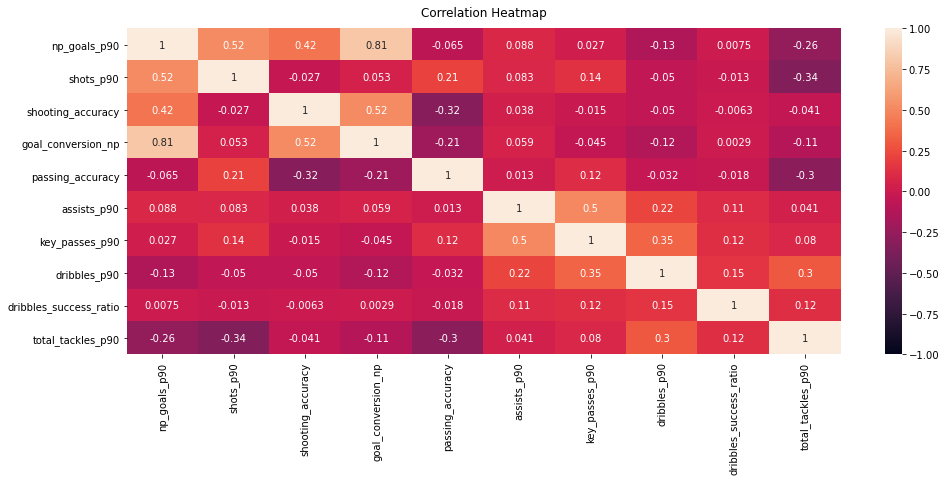

In [302]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_fw[fw_cols].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### PCA

In [243]:
pca_object = decomposition.PCA().fit(df_fw[fw_cols])

In [333]:
pca_summary(pca_object)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11
variance,2.12,1.16,0.87,0.53,0.44,0.34,0.27,0.19,0.13,0.09,0.04
proportion of variance explained,0.34,0.19,0.14,0.09,0.07,0.06,0.04,0.03,0.02,0.01,0.01
cumulative proportion,0.34,0.53,0.67,0.76,0.83,0.88,0.93,0.96,0.98,0.99,1.00


Text(0, 0.5, 'Variance')

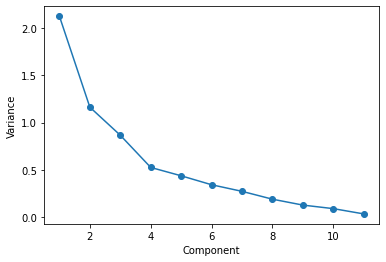

In [334]:
plt.plot(1+np.arange(len(pca_object.explained_variance_)), pca_object.explained_variance_, 'o-')
plt.xlabel('Component')
plt.ylabel('Variance')

In [335]:
my_pca_components = pca_components(pca_object, df_fw[fw_cols].columns)
my_pca_components.round(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11
wavg_player_rating,0.47,0.35,-0.09,0.12,-0.44,-0.27,0.38,-0.21,-0.41,-0.11,0.04
np_goals_p90,0.73,-0.26,-0.07,-0.21,0.16,0.02,-0.27,-0.04,0.09,0.10,-0.48
shots_p90,0.20,0.05,-0.26,-0.09,-0.08,-0.46,-0.27,0.52,0.16,0.19,0.50
shooting_accuracy,0.20,-0.14,0.26,0.03,0.08,0.25,0.64,0.61,0.04,0.12,-0.03
goal_conversion_np,0.34,-0.21,0.14,-0.07,0.19,0.35,0.02,-0.36,0.02,-0.11,0.72
passing_accuracy,-0.05,0.21,-0.82,-0.20,0.20,0.39,0.20,0.01,-0.07,0.12,-0.00
assists_p90,0.18,0.59,0.16,0.51,0.41,0.20,-0.30,0.17,-0.11,0.03,-0.01
key_passes_p90,0.09,0.36,0.02,0.02,-0.00,-0.11,0.27,-0.26,0.84,0.04,-0.04
dribbles_p90,-0.04,0.44,0.32,-0.78,0.20,-0.07,-0.00,0.06,-0.15,-0.13,0.00
dribbles_success_ratio,0.04,0.17,0.08,-0.12,-0.69,0.57,-0.31,0.17,0.15,-0.01,-0.00


In [336]:
pca_embedding = decomposition.PCA(n_components=10).fit_transform(df_fw[fw_cols])
pca_embedding.shape

(2266, 10)

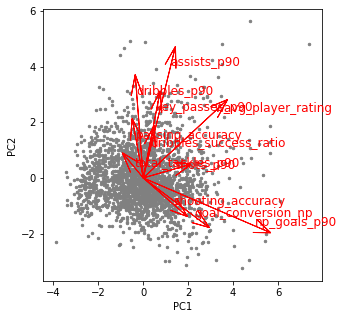

In [337]:
biplot(pca_embedding, my_pca_components)

#### Factor Analysis

**Princeton - Factor Analysis**

Uniqueness is the variance that is ‘unique’ to the variable and not shared with other variables. It is equal to 1 – communality
(variance that is shared with other variables). For example, 61.57% of the variance in ‘ideol’ is not share with other
variables in the overall factor model. On the contrary ‘owner’ has low variance not accounted by other variables (28.61%).
Notice that the greater ‘uniqueness’ the lower the relevance of the variable in the factor model.

The higher the communalities, the better for aggregating in a factor with other variables.

By default the rotation is varimax which produces orthogonal factors. This means that factors are not correlated to each other.
**This setting is recommended when you want to identify variables to create indexes or new variables without inter-correlated components**

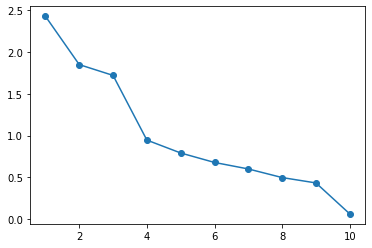

In [24]:
# Subset of the data, the 14 columns containing the survey answers
x = df_fw[fw_cols]
fa = FactorAnalyzer()
fa.fit(x, 10)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev,marker='o')

In [25]:
ev

array([2.42985838, 1.85018515, 1.72067068, 0.94522991, 0.79051087,
       0.67697769, 0.59904634, 0.49591664, 0.43148002, 0.06012433])

In [26]:
factors=4
method='principal'
rotation='varimax'
fa = FactorAnalyzer(factors, method=method, rotation=rotation)
fa.fit(x)
loads = fa.loadings_

In [27]:
variances = fa.get_factor_variance()[0]
sq_norm_variances = (loads**2)/variances
variances_pct = [variances[i]/sum(variances) for i in range(len(variances))]

In [28]:
display(get_factors(x, factors=4, method='principal', rotation='varimax')[0])
display(get_factors(x, factors=4, method='principal', rotation='varimax')[1])

,Factor 1,Factor 2,Factor 3,Factor 4,Communalities,Sq Norm Factor 1,Sq Norm Factor 2,Sq Norm Factor 3,Sq Norm Factor 4,PC_Weight
np_goals_p90,0.83,0.45,0.04,0.08,0.89,0.30,0.11,0.00,0.01,0.13
shots_p90,0.17,0.76,0.14,0.09,0.63,0.01,0.31,0.01,0.01,0.09
shooting_accuracy,0.76,-0.18,0.00,-0.07,0.62,0.25,0.02,0.00,0.01,0.09
goal_conversion_np,0.89,0.08,-0.03,0.02,0.81,0.34,0.00,0.00,0.00,0.12
passing_accuracy,-0.43,0.64,0.06,0.01,0.60,0.08,0.22,0.00,0.00,0.09
assists_p90,0.10,0.06,0.79,-0.05,0.63,0.00,0.00,0.35,0.00,0.09
key_passes_p90,-0.03,0.11,0.85,0.03,0.73,0.00,0.01,0.40,0.00,0.10
dribbles_p90,-0.12,-0.27,0.61,0.22,0.50,0.01,0.04,0.21,0.05,0.07
dribbles_success_ratio,0.01,-0.03,0.08,0.96,0.93,0.00,0.00,0.00,0.90,0.13
total_tackles_p90,-0.09,-0.72,0.21,0.18,0.60,0.00,0.28,0.02,0.03,0.09


,Factor,C-Alpha,Conf. Interval
0,Sq Norm Factor 1,0.80,"[0.783, 0.812]"
1,Sq Norm Factor 2,0.35,"[0.293, 0.4]"
2,Sq Norm Factor 3,0.63,"[0.601, 0.654]"


In [29]:
df_factors_fw = get_factors(x, factors=4, method='principal', rotation='varimax')[0]
df_variances_fw = df_factors_fw.iloc[df_factors_fw.index == 'Expl.Var/Tot (%)', 0:4]
df_variances_fw

,Factor 1,Factor 2,Factor 3,Factor 4
Expl.Var/Tot (%),0.33,0.26,0.26,0.15


In [30]:
weights = np.array(df_factors_fw.iloc[:-(len(df_factors_fw)-len(fw_cols)), -1])

In [31]:
weights_f1 = np.array(df_factors_fw.iloc[:-(len(df_factors_fw)-len(fw_cols)), -5])
weights_f2 = np.array(df_factors_fw.iloc[:-(len(df_factors_fw)-len(fw_cols)), -4])
weights_f3 = np.array(df_factors_fw.iloc[:-(len(df_factors_fw)-len(fw_cols)), -3])
weights_f4 = np.array(df_factors_fw.iloc[:-(len(df_factors_fw)-len(fw_cols)), -2])

In [32]:
df_perf_idx = df_fw[df_fw['player_preferred_position']=='F'].set_index(['player_id', 'player_name'])[fw_cols]

In [33]:
df_perf_idx['Factor_1'] = np.sum(df_perf_idx[fw_cols]*weights_f1, axis=1)
df_perf_idx['Factor_2'] = np.sum(df_perf_idx[fw_cols]*weights_f2, axis=1)
df_perf_idx['Factor_3'] = np.sum(df_perf_idx[fw_cols]*weights_f3, axis=1)
df_perf_idx['Factor_4'] = np.sum(df_perf_idx[fw_cols]*weights_f4, axis=1)
df_perf_idx['Perf_Index'] = np.sum(df_perf_idx[fw_cols]*weights, axis=1)

In [34]:
df_perf_idx['Perf_Index'].describe()

count   2266.00
mean       0.02
std        0.36
min       -1.48
25%       -0.19
50%        0.03
75%        0.23
max        1.66
Name: Perf_Index, dtype: float64

In [35]:
df_perf_idx

,,np_goals_p90,shots_p90,shooting_accuracy,goal_conversion_np,passing_accuracy,assists_p90,key_passes_p90,dribbles_p90,dribbles_success_ratio,total_tackles_p90,Factor_1,Factor_2,Factor_3,Factor_4,Perf_Index
player_id,player_name,,,,,,,,,,,,,,,
18,Jadon Sancho,0.93,-0.59,0.98,1.95,-0.21,3.23,3.22,2.47,0.41,0.05,1.20,0.04,2.93,0.50,1.23
21,Paco Alcacer,1.50,0.30,0.73,1.44,-0.09,0.71,0.10,-0.64,0.20,-0.28,1.12,0.15,0.15,0.16,0.47
24,Maximilian Philipp,0.95,0.23,0.11,0.92,-0.63,0.06,0.07,0.28,0.13,0.22,0.58,0.11,0.11,0.14,0.27
54,Diego Costa,0.74,0.39,-0.02,0.56,0.44,0.85,0.18,0.72,-0.51,-0.11,0.46,0.30,0.52,-0.42,0.30
56,Antoine Griezmann,1.01,0.40,0.55,0.83,0.01,0.90,1.11,-0.18,0.18,0.05,0.73,0.27,0.73,0.17,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278497,Bruno Marques,1.63,1.07,0.29,0.91,-2.66,-0.73,-0.43,0.08,0.00,2.15,0.68,0.54,-0.35,0.09,0.29
288707,Kevin Zenon,-1.14,-1.25,0.78,-1.33,-2.71,1.11,-0.04,0.24,1.11,0.12,-0.83,-1.06,0.40,1.00,-0.30
295023,Indio,-0.12,-1.62,-0.52,2.66,-2.70,-0.73,0.54,1.47,-0.66,0.95,0.52,-0.79,0.27,-0.51,-0.04


In [36]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

df_perf_idx['Perf_Index_scaled']=MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Perf_Index']))

In [37]:
df_perf_idx.sort_values('Perf_Index_scaled', ascending=False).head(30)

,,np_goals_p90,shots_p90,shooting_accuracy,goal_conversion_np,passing_accuracy,assists_p90,key_passes_p90,dribbles_p90,dribbles_success_ratio,total_tackles_p90,Factor_1,Factor_2,Factor_3,Factor_4,Perf_Index,Perf_Index_scaled
player_id,player_name,,,,,,,,,,,,,,,,
154,Lionel Messi,2.90,3.30,0.74,0.64,0.05,2.31,3.14,3.10,1.01,-0.62,1.34,1.35,2.74,1.08,1.66,1.00
276,Neymar,1.31,1.78,0.46,0.31,0.24,2.33,4.08,4.05,0.73,-0.48,0.69,0.82,3.31,0.86,1.42,0.92
91371,Francesco Totti,1.10,2.94,-0.65,-0.16,0.48,4.56,6.57,-0.09,-0.47,-0.27,0.21,1.11,4.24,-0.40,1.39,0.91
195090,Peglow,1.28,-0.66,2.08,2.66,-1.92,4.98,3.40,0.74,-0.55,1.23,1.69,-0.04,3.28,-0.39,1.33,0.89
18,Jadon Sancho,0.93,-0.59,0.98,1.95,-0.21,3.23,3.22,2.47,0.41,0.05,1.20,0.04,2.93,0.50,1.23,0.86
278,Kylian Mbappe,2.98,1.84,1.25,1.38,-0.40,1.60,1.59,2.09,0.19,-0.71,1.68,0.74,1.64,0.29,1.22,0.86
5190,Joaquin Viviani,1.33,-1.47,2.08,6.65,-0.18,1.21,0.07,-0.44,0.00,1.57,3.18,0.13,0.38,0.04,1.20,0.85
39552,Carlos Orejuela,0.33,-0.97,2.73,1.66,0.21,3.89,1.61,0.21,0.47,1.77,1.38,0.36,2.08,0.51,1.16,0.84
37162,Robin van Persie,2.68,2.09,0.78,1.04,0.79,0.70,1.06,0.29,1.33,-0.46,1.44,1.03,0.75,1.23,1.13,0.83


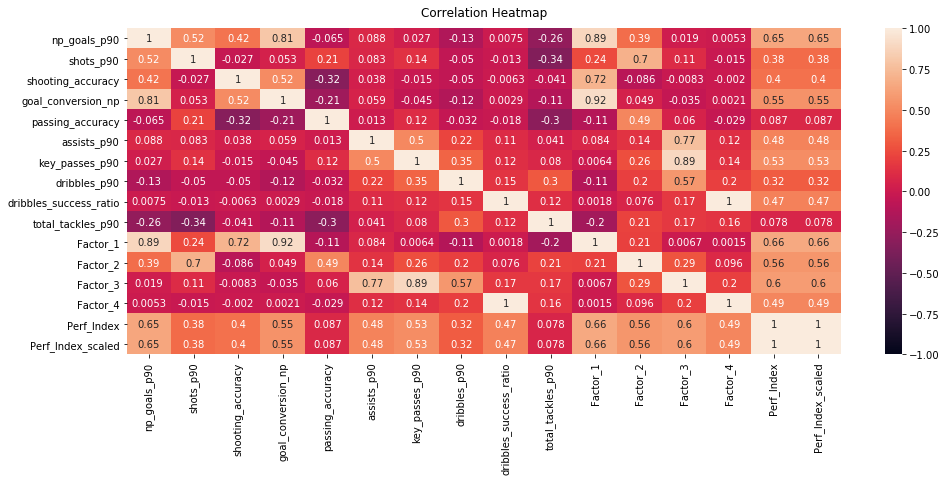

In [38]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_perf_idx.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [39]:
dict_weights = {}
dict_weights['Forwards'] = df_factors_fw['PC_Weight'].dropna().to_dict()

#### Validation

In [40]:
cols_factors = ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Perf_Index_scaled']
df_validation = pd.concat([df[df['player_preferred_position']=='F'][player_cols+fw_cols+['wavg_player_rating']].set_index(['player_id', 'player_name']), df_perf_idx[cols_factors]], axis=1)

In [41]:
df_validation

,,player_preferred_position,player_preferred_number,player_minutes,np_goals_p90,shots_p90,shooting_accuracy,goal_conversion_np,passing_accuracy,assists_p90,key_passes_p90,dribbles_p90,dribbles_success_ratio,total_tackles_p90,wavg_player_rating,Factor_1,Factor_2,Factor_3,Factor_4,Perf_Index_scaled
player_id,player_name,,,,,,,,,,,,,,,,,,,
18,Jadon Sancho,F,7,7508,0.44,1.62,0.53,0.27,0.58,0.54,2.76,6.13,0.56,0.99,7.50,1.20,0.04,2.93,0.50,0.86
21,Paco Alcacer,F,17,8281,0.57,2.45,0.49,0.23,0.61,0.20,1.08,0.72,0.53,0.67,7.04,1.12,0.15,0.15,0.16,0.62
24,Maximilian Philipp,F,20,5025,0.45,2.38,0.41,0.19,0.49,0.11,1.06,2.31,0.52,1.14,7.02,0.58,0.11,0.11,0.14,0.56
54,Diego Costa,F,19,9191,0.40,2.54,0.40,0.16,0.73,0.22,1.12,3.07,0.42,0.84,6.95,0.46,0.30,0.52,-0.42,0.57
56,Antoine Griezmann,F,7,17043,0.46,2.55,0.47,0.18,0.63,0.22,1.62,1.52,0.53,0.99,7.35,0.73,0.27,0.73,0.17,0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278497,Bruno Marques,F,19,455,0.59,3.16,0.44,0.19,0.03,0.00,0.79,1.98,0.50,2.99,6.73,0.68,0.54,-0.35,0.09,0.56
288707,Kevin Zenon,F,34,360,0.00,1.00,0.50,0.00,0.02,0.25,1.00,2.25,0.67,1.06,6.63,-0.83,-1.06,0.40,1.00,0.37
295023,Indio,F,10,411,0.22,0.66,0.33,0.33,0.03,0.00,1.31,4.38,0.40,1.84,6.46,0.52,-0.79,0.27,-0.51,0.46


In [42]:
## Initial Model
x_cols = ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4']
target = ['Perf_Index_scaled']

train = df_validation[x_cols+target]

x_train = train[x_cols]
y_train = train[target]

x_train['const'] = 1.0

# OLS
model_ols = sm.OLS(y_train, x_train).fit()
y_train_ols = model_ols.predict(x_train)

model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Perf_Index_scaled   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.328e+31
Date:                Sat, 23 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:53:10   Log-Likelihood:                 77665.
No. Observations:                2266   AIC:                        -1.553e+05
Df Residuals:                    2261   BIC:                        -1.553e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Factor_1       0.1061   1.07e-17   9.96e+15      0.000       0.106       0.106
Factor_2       0.0834   1.89e-17   4.41e+15      0.000       0.083       0.083
Factor_3       0.0813   1.13e-17   7.17e+15      0.000       0.081       0.081
Factor_4       0.0472   7.44e-18   6.35e+15      0.000       0.047       0.047
const          0.4710   6.78e-18   6.95e+16      0.000       0.471       0.471
==============================================================================
Omnibus:                       48.751   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.734
Skew:                          -0.069   Prob(JB):                     1.34e-22
Kurtosis:                       4.024   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Midfielders

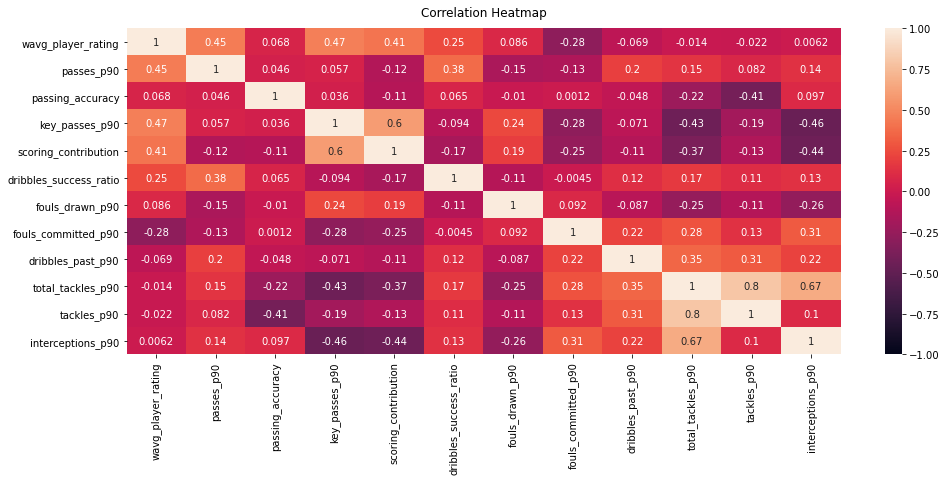

In [323]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_mf[mf_cols].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### PCA

In [324]:
pca_object = decomposition.PCA().fit(df_mf[mf_cols])

In [419]:
pca_summary(pca_object)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12
variance,1.50,1.10,0.97,0.63,0.46,0.40,0.35,0.31,0.24,0.16,0.11,0.00
proportion of variance explained,0.24,0.18,0.15,0.10,0.07,0.07,0.06,0.05,0.04,0.03,0.02,0.00
cumulative proportion,0.24,0.42,0.57,0.67,0.75,0.81,0.87,0.92,0.96,0.98,1.00,1.00


Text(0, 0.5, 'Variance')

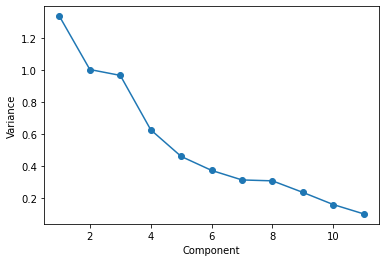

In [374]:
plt.plot(1+np.arange(len(pca_object.explained_variance_)), pca_object.explained_variance_, 'o-')
plt.xlabel('Component')
plt.ylabel('Variance')

In [375]:
my_pca_components = pca_components(pca_object, df_mf[mf_cols].columns)
my_pca_components.round(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11
wavg_player_rating,0.53,0.40,-0.10,0.15,-0.14,0.40,0.15,0.20,0.27,-0.04,-0.46
passes_p90,0.14,0.48,-0.26,-0.00,-0.10,-0.10,-0.41,0.29,-0.53,0.26,0.24
passing_accuracy,0.15,-0.33,-0.77,0.15,0.23,-0.09,0.40,0.07,-0.11,0.10,0.05
key_passes_p90,0.48,-0.02,0.15,0.19,0.28,0.03,-0.06,-0.23,-0.32,-0.64,0.24
scoring_contribution,0.37,-0.05,0.25,0.10,0.24,0.20,0.06,-0.26,0.16,0.64,0.42
dribbles_success_ratio,0.01,0.38,-0.27,0.03,-0.39,-0.30,0.11,-0.70,0.16,-0.04,0.10
fouls_drawn_p90,0.17,-0.22,0.20,0.61,-0.42,-0.45,0.02,0.31,0.13,0.02,0.12
fouls_committed_p90,-0.38,-0.06,-0.05,0.62,-0.12,0.53,-0.09,-0.25,-0.29,0.07,-0.10
dribbles_past_p90,-0.19,0.32,-0.05,0.38,0.65,-0.32,-0.24,-0.01,0.32,0.02,-0.18
tackles_p90,-0.24,0.42,0.28,0.08,0.11,-0.07,0.75,0.17,-0.25,-0.01,0.14


In [376]:
pca_embedding = decomposition.PCA(n_components=10).fit_transform(df_mf[mf_cols])
pca_embedding.shape

(4330, 10)

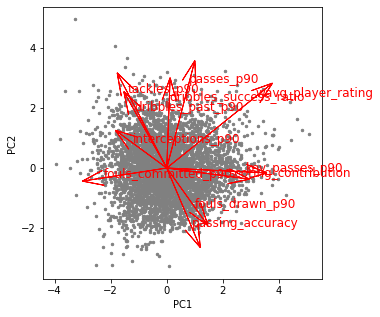

In [377]:
biplot(pca_embedding, my_pca_components)

#### Factor Analysis

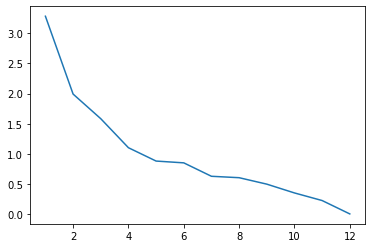

In [49]:
# Subset of the data, the 14 columns containing the survey answers
x = df_mf[mf_cols]
fa = FactorAnalyzer()
fa.fit(x, 10)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev)

In [50]:
factors=5
method='principal'
rotation='varimax'
fa = FactorAnalyzer(factors, method=method, rotation=rotation)
fa.fit(x)
loads = fa.loadings_

In [51]:
display(get_factors(x, factors=4, method='principal', rotation='varimax')[0])
display(get_factors(x, factors=4, method='principal', rotation='varimax')[1])

,Factor 1,Factor 2,Factor 3,Factor 4,Communalities,Sq Norm Factor 1,Sq Norm Factor 2,Sq Norm Factor 3,Sq Norm Factor 4,PC_Weight
wavg_player_rating,0.50,0.71,-0.00,0.07,0.75,0.09,0.25,0.00,0.00,0.09
passes_p90,-0.03,0.81,0.03,0.06,0.65,0.00,0.33,0.00,0.00,0.08
passing_accuracy,-0.15,0.22,-0.75,-0.13,0.65,0.01,0.02,0.28,0.01,0.08
key_passes_p90,0.83,0.16,-0.11,0.05,0.72,0.25,0.01,0.01,0.00,0.09
scoring_contribution,0.81,-0.02,0.05,0.11,0.68,0.24,0.00,0.00,0.01,0.08
dribbles_success_ratio,-0.17,0.64,-0.01,-0.02,0.44,0.01,0.21,0.00,0.00,0.06
fouls_drawn_p90,0.51,-0.21,-0.17,-0.51,0.60,0.10,0.02,0.01,0.20,0.08
fouls_committed_p90,0.29,0.19,-0.02,0.76,0.69,0.03,0.02,0.00,0.43,0.09
dribbles_past_p90,0.10,-0.26,-0.31,0.51,0.44,0.00,0.03,0.05,0.20,0.05
total_tackles_p90,-0.51,0.27,0.69,-0.28,0.88,0.09,0.04,0.24,0.06,0.11


,Factor,C-Alpha,Conf. Interval
0,Sq Norm Factor 1,0.61,"[0.585, 0.625]"
1,Sq Norm Factor 2,0.62,"[0.6, 0.639]"
2,Sq Norm Factor 3,0.89,"[0.881, 0.895]"
3,Sq Norm Factor 4,0.36,"[0.316, 0.393]"


In [52]:
df_factors_mf = get_factors(x, factors=4, method='principal', rotation='varimax')[0]
df_variances_mf = df_factors_mf.iloc[df_factors_mf.index == 'Expl.Var/Tot (%)', 0:4]
df_variances_mf

,Factor 1,Factor 2,Factor 3,Factor 4
Expl.Var/Tot (%),0.34,0.25,0.25,0.17


In [53]:
weights_f1 = np.array(df_factors_mf.iloc[:-(len(df_factors_mf)-len(mf_cols)), -5])
weights_f2 = np.array(df_factors_mf.iloc[:-(len(df_factors_mf)-len(mf_cols)), -4])
weights_f3 = np.array(df_factors_mf.iloc[:-(len(df_factors_mf)-len(mf_cols)), -3])
weights_f4 = np.array(df_factors_mf.iloc[:-(len(df_factors_mf)-len(mf_cols)), -2])
#weights_f5 = np.array(df_factors_mf.iloc[:-(len(df_factors_mf)-len(mf_cols)), -2])
weights = np.array(df_factors_mf.iloc[:-(len(df_factors_mf)-len(mf_cols)), -1])

In [54]:
df_perf_idx = df_mf[df_mf['player_preferred_position']=='M'].set_index(['player_id', 'player_name'])[mf_cols]

In [55]:
df_perf_idx['Factor_1'] = np.sum(df_perf_idx[mf_cols]*weights_f1, axis=1)
df_perf_idx['Factor_2'] = np.sum(df_perf_idx[mf_cols]*weights_f2, axis=1)
df_perf_idx['Factor_3'] = np.sum(df_perf_idx[mf_cols]*weights_f3, axis=1)
df_perf_idx['Factor_4'] = np.sum(df_perf_idx[mf_cols]*weights_f4, axis=1)
#df_perf_idx['Factor_5'] = np.sum(df_perf_idx[mf_cols]*weights_f5, axis=1)
df_perf_idx['Perf_Index'] = np.sum(df_perf_idx[mf_cols]*weights, axis=1)

In [56]:
df_perf_idx['Perf_Index'].describe()

count   4330.00
mean       0.03
std        0.26
min       -1.09
25%       -0.14
50%        0.03
75%        0.20
max        1.04
Name: Perf_Index, dtype: float64

In [57]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

df_perf_idx['Perf_Index_scaled']=MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Perf_Index']))

In [58]:
df_perf_idx.sort_values('Perf_Index_scaled', ascending=False).head(20)

,,wavg_player_rating,passes_p90,passing_accuracy,key_passes_p90,scoring_contribution,dribbles_success_ratio,fouls_drawn_p90,fouls_committed_p90,dribbles_past_p90,total_tackles_p90,tackles_p90,interceptions_p90,Factor_1,Factor_2,Factor_3,Factor_4,Perf_Index,Perf_Index_scaled
player_id,player_name,,,,,,,,,,,,,,,,,,
80792,David Pizarro,2.43,1.38,0.43,1.76,1.73,1.43,2.33,1.13,0.18,-0.09,-0.16,0.25,1.40,1.50,0.09,1.03,1.04,1.00
629,Kevin De Bruyne,3.36,1.36,-0.07,2.98,2.71,0.32,-0.34,0.83,-0.95,-0.30,0.21,-0.63,1.59,1.34,-0.04,0.09,0.87,0.92
2990,Idrissa Gueye,1.37,1.62,0.02,-0.32,-0.36,0.28,0.02,-0.27,-0.36,2.72,2.58,1.49,0.46,1.11,1.68,0.14,0.87,0.92
517,James Rodriguez,3.32,1.76,-0.09,2.65,3.02,-0.36,0.14,0.82,-0.29,-0.60,-0.28,-0.50,1.61,1.34,-0.27,0.30,0.86,0.91
507,Thiago Alcantara,2.89,3.44,0.19,0.74,0.45,0.65,-0.24,0.23,0.20,0.40,0.11,0.71,0.70,2.08,0.21,0.19,0.84,0.90
114433,Eduardo Camavinga,1.24,0.31,0.67,-0.82,-0.16,0.88,1.02,-0.21,-1.48,2.69,3.22,0.56,0.33,0.72,2.06,0.09,0.81,0.89
48528,Alex Song,0.57,1.35,0.57,0.08,-0.76,0.95,-0.45,-0.15,-3.34,3.18,4.12,0.64,0.27,0.85,2.40,-0.49,0.81,0.89
44789,Youssouf Mulumbu,-0.13,0.16,0.01,-0.92,-0.76,1.24,-0.67,0.09,-0.52,3.62,4.59,0.81,0.02,0.44,2.66,0.15,0.79,0.88
39701,Alfredo Ramua,3.67,0.20,0.21,3.37,1.67,1.19,0.40,1.31,0.24,-1.09,-0.66,-0.94,1.43,1.25,-0.43,0.58,0.79,0.88


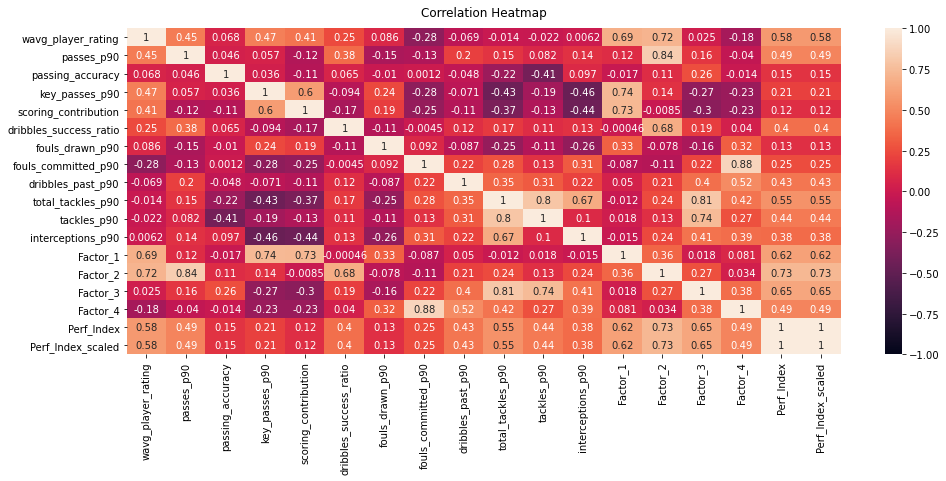

In [346]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_perf_idx.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [347]:
dict_weights['Midfielders'] = df_factors_mf['PC_Weight'].dropna().to_dict()

#### Validation

In [234]:
cols_factors = ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5', 'Perf_Index']
df_validation = pd.concat([df[df['player_preferred_position']=='M'][player_cols+mf_cols].set_index(['player_id', 'player_name']), df_perf_idx[cols_factors]], axis=1)

In [235]:
df_validation

,,player_preferred_position,player_preferred_number,player_minutes,wavg_player_rating,passes_p90,passing_accuracy,key_passes_p90,scoring_contribution,dribbles_success_ratio,fouls_drawn_p90,fouls_committed_p90,dribbles_past_p90,total_tackles_p90,tackles_p90,interceptions_p90,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Perf_Index
player_id,player_name,,,,,,,,,,,,,,,,,,,,,
9,Achraf Hakimi,M,5,7894,7.03,50.94,0.63,1.03,0.43,0.60,1.46,-0.81,-1.05,2.35,1.38,0.91,0.72,0.08,0.70,0.13,0.32,0.40
14,Mahmoud Dahoud,M,8,7974,7.10,51.90,0.66,1.25,0.33,0.63,1.22,-1.84,-1.57,2.26,0.56,1.67,0.69,-0.20,0.76,-0.08,0.12,0.28
15,Thomas Delaney,M,6,8125,7.10,43.43,0.64,0.63,0.24,0.48,1.68,-2.33,-0.74,3.40,1.20,1.95,0.37,0.15,0.32,0.17,0.33,0.27
16,Mario Gotze,M,10,6941,7.07,46.25,0.60,1.97,0.53,0.47,1.43,-1.04,-1.28,1.42,0.74,0.66,1.14,-0.20,0.37,-0.18,0.24,0.31
17,Christian Pulisic,M,22,8602,6.87,28.56,0.59,1.44,0.49,0.48,1.72,-0.67,-0.62,1.15,0.50,0.61,0.74,-0.02,-0.08,-0.28,0.38,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288011,Thiago,M,7,416,6.64,17.96,0.04,0.87,0.43,0.31,2.60,-1.07,-1.51,2.72,0.95,1.78,0.28,0.02,-0.75,-0.98,0.88,-0.12
288731,Cristian Torres,M,28,321,6.29,15.70,0.05,0.00,0.00,0.00,1.12,-0.37,-1.40,0.24,0.24,0.00,-0.93,-0.50,-1.60,-1.38,-0.12,-0.93
289446,Luciano Ferreyra,M,19,593,6.83,26.41,0.02,1.67,0.15,0.33,2.28,-1.34,-1.21,1.87,1.35,0.37,0.33,-0.24,-0.47,-0.95,0.56,-0.16


In [236]:
## Initial Model
x_cols = ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5']
target = ['Perf_Index']

train = df_validation[x_cols+target]

x_train = train[x_cols]
y_train = train[target]

x_train['const'] = 1.0

# OLS
model_ols = sm.OLS(y_train, x_train).fit()
y_train_ols = model_ols.predict(x_train)

model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Perf_Index   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.103e+33
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:37:09   Log-Likelihood:             1.5017e+05
No. Observations:                4330   AIC:                        -3.003e+05
Df Residuals:                    4324   BIC:                        -3.003e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Factor_1       0.2523   7.33e-18   3.44e+16      0.000       0.252       0.252
Factor_2       0.2305   1.25e-17   1.84e+16      0.000       0.231       0.231
Factor_3       0.1897   6.88e-18   2.76e+16      0.000       0.190       0.190
Factor_4       0.1849   8.52e-18   2.17e+16      0.000       0.185       0.185
Factor_5       0.1425   8.37e-18    1.7e+16      0.000       0.142       0.142
const       1.913e-16   4.11e-18     46.530      0.000    1.83e-16    1.99e-16
==============================================================================
Omnibus:                       71.361   Durbin-Watson:                   0.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.549
Skew:                          -0.130   Prob(JB):                     6.65e-27
Kurtosis:                       3.775   Cond. No.                         4.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Defenders

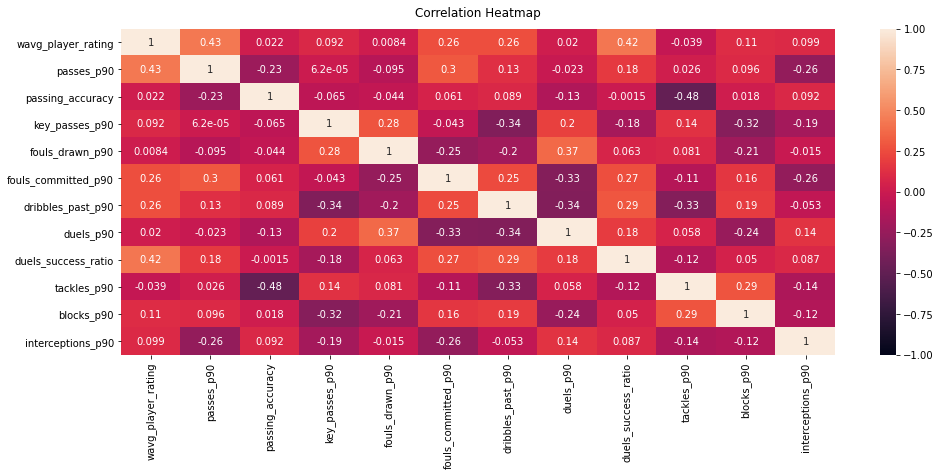

In [567]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_df[df_cols].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### PCA

In [546]:
pca_object = decomposition.PCA().fit(df_df[df_cols])

In [547]:
pca_summary(pca_object)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
variance,7.89,1.99,1.08,0.92,0.52,0.42,0.33,0.27,0.23,0.17,0.13,0.11,0.09
proportion of variance explained,0.56,0.14,0.08,0.07,0.04,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01
cumulative proportion,0.56,0.70,0.78,0.84,0.88,0.91,0.93,0.95,0.96,0.98,0.99,0.99,1.00


Text(0, 0.5, 'Variance')

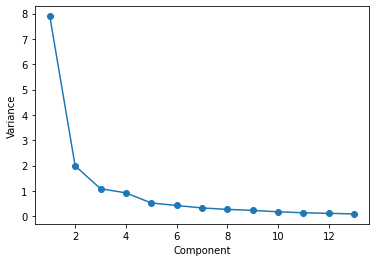

In [548]:
plt.plot(1+np.arange(len(pca_object.explained_variance_)), pca_object.explained_variance_, 'o-')
plt.xlabel('Component')
plt.ylabel('Variance')

In [549]:
my_pca_components = pca_components(pca_object, df_df[df_cols].columns)
my_pca_components.round(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
wavg_player_rating,-0.05,0.12,-0.18,-0.54,-0.21,0.34,0.44,0.25,-0.25,-0.15,-0.19,0.06,0.34
passes_p90,-0.01,0.09,0.04,-0.45,0.33,0.38,0.13,-0.42,0.31,0.36,0.24,-0.01,-0.24
passing_accuracy,-0.00,-0.02,-0.73,0.35,-0.14,0.42,-0.12,0.12,0.04,0.30,0.03,-0.12,-0.06
key_passes_p90,-0.02,-0.10,0.10,-0.01,-0.02,0.36,-0.07,0.11,-0.23,-0.38,-0.19,0.15,-0.76
fouls_drawn_p90,-0.00,-0.08,0.07,-0.01,-0.27,0.17,-0.19,-0.19,-0.44,-0.16,0.76,-0.01,0.12
fouls_committed_p90,-0.03,0.11,-0.14,-0.21,0.35,0.04,-0.31,0.37,0.31,-0.48,0.22,-0.43,0.07
dribbles_past_p90,0.01,0.10,-0.25,-0.20,0.23,-0.41,0.09,-0.03,-0.56,0.22,-0.03,-0.46,-0.28
duels_p90,-0.00,-0.11,0.11,-0.07,-0.46,0.13,-0.16,-0.45,0.11,-0.12,-0.34,-0.61,0.05
duels_success_ratio,-0.01,0.06,-0.20,-0.50,-0.40,-0.29,-0.53,0.10,0.13,0.17,-0.03,0.31,-0.15
tackles_p90,-0.00,0.17,0.52,0.03,-0.17,0.22,-0.10,0.54,-0.04,0.49,0.05,-0.28,-0.06


In [550]:
pca_embedding = decomposition.PCA(n_components=10).fit_transform(df_df[df_cols])
pca_embedding.shape

(3802, 10)

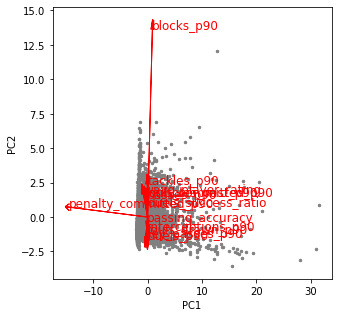

In [551]:
biplot(pca_embedding, my_pca_components)

#### Factor Analysis

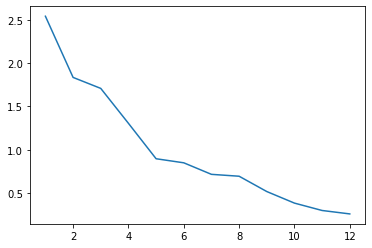

In [36]:
# Subset of the data, the 14 columns containing the survey answers
x = df_df[df_cols]
fa = FactorAnalyzer()
fa.fit(x, 10)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev)

In [37]:
factors=4
method='principal'
rotation='varimax'
fa = FactorAnalyzer(factors, method=method, rotation=rotation)
fa.fit(x)
loads = fa.loadings_

In [38]:
display(get_factors(x, factors=4, method='principal', rotation='varimax')[0])
display(get_factors(x, factors=4, method='principal', rotation='varimax')[1])

,Factor 1,Factor 2,Factor 3,Factor 4,Communalities,Sq Norm Factor 1,Sq Norm Factor 2,Sq Norm Factor 3,Sq Norm Factor 4,PC_Weight
wavg_player_rating,0.04,0.80,-0.00,0.11,0.65,0.00,0.32,0.00,0.01,0.09
passes_p90,-0.02,0.56,0.22,0.47,0.59,0.00,0.16,0.03,0.14,0.08
passing_accuracy,-0.08,-0.09,-0.74,-0.06,0.56,0.00,0.00,0.32,0.00,0.08
key_passes_p90,0.71,-0.11,0.03,0.42,0.70,0.24,0.01,0.00,0.11,0.09
fouls_drawn_p90,0.64,0.07,0.09,-0.15,0.45,0.20,0.00,0.00,0.02,0.06
fouls_committed_p90,-0.30,0.38,-0.16,0.58,0.60,0.04,0.07,0.02,0.22,0.08
dribbles_past_p90,-0.52,0.42,-0.33,0.05,0.55,0.13,0.09,0.06,0.00,0.07
duels_p90,0.65,0.19,0.20,-0.40,0.66,0.20,0.02,0.02,0.10,0.09
duels_success_ratio,-0.02,0.79,-0.06,-0.20,0.67,0.00,0.31,0.00,0.03,0.09
tackles_p90,0.01,-0.14,0.87,0.06,0.78,0.00,0.01,0.44,0.00,0.11


,Factor,C-Alpha,Conf. Interval
0,Sq Norm Factor 1,0.55,"[0.524, 0.574]"
1,Sq Norm Factor 2,0.59,"[0.565, 0.61]"


In [39]:
df_factors_df = get_factors(x, factors=5, method='principal', rotation='varimax')[0]
df_variances_df = df_factors_df.iloc[df_factors_df.index == 'Expl.Var/Tot (%)', 0:5]
df_variances_df

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Expl.Var/Tot (%),0.25,0.23,0.19,0.18,0.16


In [40]:
weights_f1 = np.array(df_factors_df.iloc[:-(len(df_factors_df)-len(df_cols)), -5])
weights_f2 = np.array(df_factors_df.iloc[:-(len(df_factors_df)-len(df_cols)), -4])
weights_f3 = np.array(df_factors_df.iloc[:-(len(df_factors_df)-len(df_cols)), -3])
weights_f4 = np.array(df_factors_df.iloc[:-(len(df_factors_df)-len(df_cols)), -2])
weights_f5 = np.array(df_factors_df.iloc[:-(len(df_factors_df)-len(df_cols)), -2])
weights = np.array(df_factors_df.iloc[:-(len(df_factors_df)-len(df_cols)), -1])

In [41]:
df_perf_idx = df_df[df_df['player_preferred_position']=='D'].set_index(['player_id', 'player_name'])[df_cols]

In [42]:
df_perf_idx['Factor_1'] = np.sum(df_perf_idx[df_cols]*weights_f1, axis=1)
df_perf_idx['Factor_2'] = np.sum(df_perf_idx[df_cols]*weights_f2, axis=1)
df_perf_idx['Factor_3'] = np.sum(df_perf_idx[df_cols]*weights_f3, axis=1)
df_perf_idx['Factor_4'] = np.sum(df_perf_idx[df_cols]*weights_f4, axis=1)
df_perf_idx['Factor_5'] = np.sum(df_perf_idx[df_cols]*weights_f5, axis=1)
df_perf_idx['Perf_Index'] = np.sum(df_perf_idx[df_cols]*weights, axis=1)

In [43]:
df_perf_idx['Perf_Index'].describe()

count   3802.00
mean       0.02
std        0.26
min       -1.38
25%       -0.13
50%        0.03
75%        0.18
max        1.01
Name: Perf_Index, dtype: float64

In [44]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

df_perf_idx['Perf_Index_scaled']=MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Perf_Index']))

In [45]:
df_perf_idx.sort_values('Perf_Index_scaled', ascending=False).head(20)

,,wavg_player_rating,passes_p90,passing_accuracy,key_passes_p90,fouls_drawn_p90,fouls_committed_p90,dribbles_past_p90,duels_p90,duels_success_ratio,tackles_p90,blocks_p90,interceptions_p90,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Perf_Index,Perf_Index_scaled
player_id,player_name,,,,,,,,,,,,,,,,,,,
38686,Dorian Dervite,0.47,-0.83,-0.15,0.29,-0.46,0.07,-0.15,0.23,0.51,1.13,7.97,1.18,0.06,0.26,0.67,4.93,4.93,1.01,1.00
19204,Curtis Davies,0.95,-0.08,0.49,-0.46,0.16,0.96,0.39,0.38,0.89,0.78,3.80,2.75,0.31,0.54,1.47,2.35,2.35,0.97,0.99
30557,Darijo Srna,1.48,0.85,0.37,3.19,4.03,0.33,0.91,0.44,1.15,-0.21,0.04,-1.21,2.07,0.30,0.15,0.58,0.58,0.91,0.96
19066,Grant Hanley,0.56,0.57,0.48,-0.63,1.16,0.48,0.47,0.47,1.71,0.65,3.23,0.57,0.64,0.56,0.41,1.98,1.98,0.85,0.94
290,Virgil van Dijk,2.12,2.08,0.56,-0.16,-0.18,1.01,1.04,0.58,2.07,0.15,1.01,-0.23,0.36,0.60,0.30,0.72,0.72,0.82,0.92
502,Joshua Kimmich,3.08,3.01,0.11,3.51,1.69,0.90,-0.72,-0.24,0.13,-0.25,-0.20,-1.10,1.02,0.22,0.43,0.44,0.44,0.80,0.91
90641,Timo Hubers,0.87,-0.38,0.17,0.53,2.14,-1.38,-1.16,1.26,0.26,1.15,4.17,0.53,0.99,0.39,0.23,2.72,2.72,0.79,0.91
6898,Ritchie De Laet,-0.13,-0.85,-0.39,0.96,-0.58,0.41,-0.66,1.27,-0.32,2.57,3.91,1.78,0.31,0.57,1.14,2.83,2.83,0.77,0.90
9739,Lenon,1.82,0.66,0.50,1.65,-0.16,0.54,1.37,0.38,1.36,0.80,-0.21,0.47,0.49,0.67,0.71,0.34,0.34,0.74,0.89


In [46]:
df_perf_idx.reset_index()[df_perf_idx.reset_index()['player_name']=='Presnel Kimpembe']

,player_id,player_name,wavg_player_rating,passes_p90,passing_accuracy,key_passes_p90,fouls_drawn_p90,fouls_committed_p90,dribbles_past_p90,duels_p90,duels_success_ratio,tackles_p90,blocks_p90,interceptions_p90,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Perf_Index,Perf_Index_scaled
74,262,Presnel Kimpembe,0.89,2.81,-0.17,-0.32,1.05,0.43,0.62,-0.25,0.69,-0.10,-0.07,-0.90,0.44,0.18,-0.19,-0.04,-0.04,0.35,0.73


In [47]:
df_perf_idx.reset_index()[df_perf_idx.reset_index()['player_name']=='Gerard Pique']

,player_id,player_name,wavg_player_rating,passes_p90,passing_accuracy,key_passes_p90,fouls_drawn_p90,fouls_committed_p90,dribbles_past_p90,duels_p90,duels_success_ratio,tackles_p90,blocks_p90,interceptions_p90,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Perf_Index,Perf_Index_scaled
36,136,Gerard Pique,1.43,2.46,0.39,-0.31,-0.55,0.93,0.48,-0.57,1.02,-0.44,0.50,-0.96,-0.18,0.29,-0.17,0.24,0.24,0.34,0.72


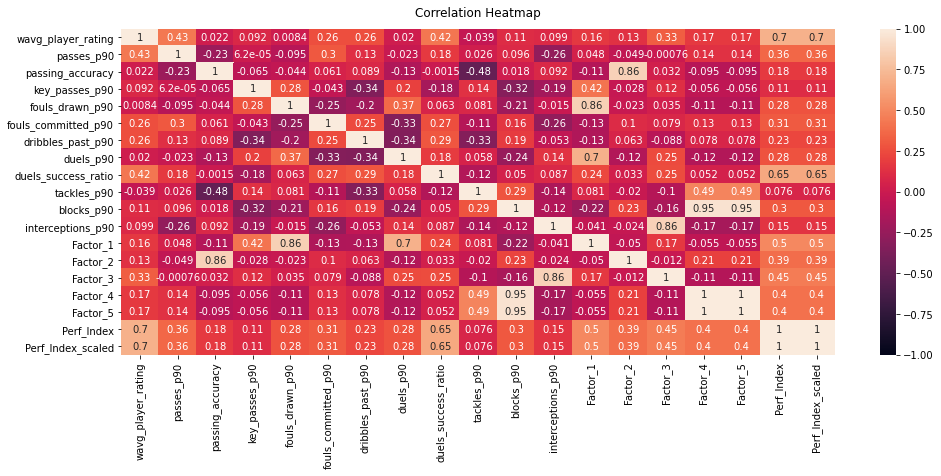

In [48]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_perf_idx.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [371]:
dict_weights['Defenders'] = df_factors_df['PC_Weight'].dropna().to_dict()

### Goalkeepers

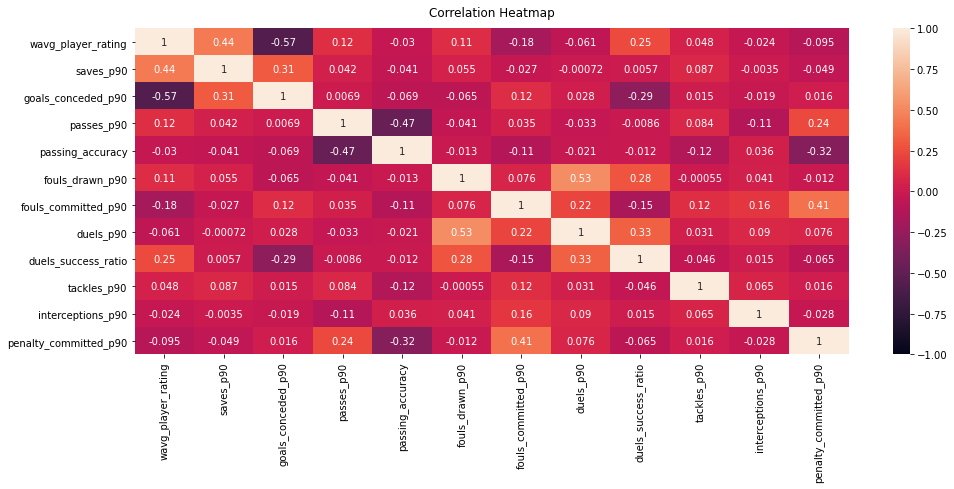

In [372]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_gk[gk_cols].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### PCA

In [466]:
pca_object = decomposition.PCA().fit(df_gk[gk_cols])

In [467]:
pca_summary(pca_object)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14
variance,3.65,1.47,0.81,0.49,0.41,0.08,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00
proportion of variance explained,0.52,0.21,0.12,0.07,0.06,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cumulative proportion,0.52,0.73,0.85,0.92,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Text(0, 0.5, 'Variance')

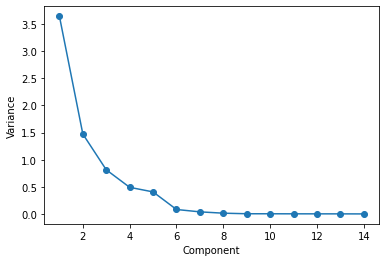

In [468]:
plt.plot(1+np.arange(len(pca_object.explained_variance_)), pca_object.explained_variance_, 'o-')
plt.xlabel('Component')
plt.ylabel('Variance')

In [469]:
my_pca_components = pca_components(pca_object, df_gk[gk_cols].columns)
my_pca_components.round(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14
wavg_player_rating,-0.14,-0.08,0.84,0.19,-0.23,0.03,0.43,-0.02,0.01,0.02,-0.01,-0.01,-0.00,0.00
saves_p90,-0.01,-0.04,0.47,-0.16,0.74,-0.08,-0.45,0.01,-0.01,-0.01,0.00,0.00,-0.01,-0.00
goals_conceded_p90,0.08,0.01,-0.18,-0.27,0.54,0.15,0.76,-0.03,-0.00,0.02,0.00,0.00,0.00,0.00
passes_p90,0.00,0.09,0.08,-0.18,-0.09,0.96,-0.18,0.03,0.01,0.01,0.01,0.00,-0.01,0.00
passing_accuracy,-0.00,-0.30,-0.16,0.86,0.30,0.23,0.01,0.01,-0.00,0.00,-0.00,0.00,0.01,0.00
key_passes_p90,0.00,-0.00,0.00,0.00,0.01,0.00,0.01,0.03,0.83,-0.50,0.21,0.09,0.01,-0.01
fouls_drawn_p90,-0.02,0.00,0.00,-0.00,0.01,-0.03,0.04,0.96,-0.13,-0.08,0.13,0.17,0.01,-0.02
fouls_committed_p90,0.01,0.02,-0.00,0.01,0.01,-0.01,-0.01,0.08,0.36,0.46,-0.57,0.53,-0.21,-0.00
duels_p90,-0.01,0.01,-0.01,-0.00,0.01,-0.01,0.00,0.25,0.28,0.15,-0.42,-0.81,0.00,0.03
duels_success_ratio,-0.98,0.08,-0.14,-0.03,0.08,0.01,0.01,-0.02,0.00,0.00,0.00,0.01,0.00,-0.00


In [470]:
pca_embedding = decomposition.PCA(n_components=10).fit_transform(df_gk[gk_cols])
pca_embedding.shape

(873, 10)

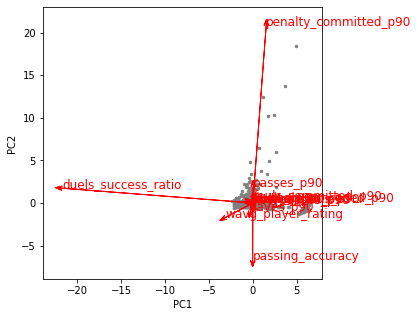

In [471]:
biplot(pca_embedding, my_pca_components)

#### Factor Analysis

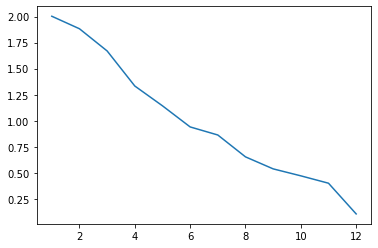

In [16]:
# Subset of the data, the 14 columns containing the survey answers
x = df_gk[gk_cols]
fa = FactorAnalyzer()
fa.fit(x, 10)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev)

In [17]:
factors=5
method='principal'
rotation='varimax'
fa = FactorAnalyzer(factors, method=method, rotation=rotation)
fa.fit(x)
loads = fa.loadings_

In [23]:
display(get_factors(x, factors=5, method='principal', rotation='varimax')[0])
display(get_factors(x, factors=5, method='principal', rotation='varimax')[1])

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Communalities,Sq Norm Factor 1,Sq Norm Factor 2,Sq Norm Factor 3,Sq Norm Factor 4,Sq Norm Factor 5,PC_Weight
wavg_player_rating,-0.06,0.04,0.79,0.50,-0.00,0.88,0.00,0.00,0.36,0.17,0.00,0.11
saves_p90,-0.02,0.05,-0.06,0.93,0.04,0.88,0.00,0.00,0.00,0.62,0.00,0.11
goals_conceded_p90,0.02,0.02,0.91,-0.31,0.04,0.92,0.00,0.00,0.47,0.07,0.00,0.11
passes_p90,-0.77,-0.07,0.09,0.11,-0.13,0.64,0.33,0.00,0.00,0.01,0.01,0.08
passing_accuracy,0.79,-0.02,0.01,-0.08,-0.00,0.63,0.35,0.00,0.00,0.00,0.00,0.08
fouls_drawn_p90,0.02,0.81,0.04,0.08,0.02,0.67,0.00,0.37,0.00,0.00,0.00,0.08
fouls_committed_p90,0.27,-0.15,0.26,0.17,-0.68,0.65,0.04,0.01,0.04,0.02,0.35,0.08
duels_p90,-0.02,0.85,-0.12,-0.05,0.15,0.77,0.00,0.41,0.01,0.00,0.02,0.10
duels_success_ratio,0.02,0.59,0.43,-0.02,-0.19,0.58,0.00,0.20,0.11,0.00,0.03,0.07
tackles_p90,-0.12,-0.08,0.07,0.28,0.49,0.34,0.01,0.00,0.00,0.06,0.18,0.04


,Factor,C-Alpha,Conf. Interval
0,Sq Norm Factor 1,0.03,"[-0.11, 0.149]"
1,Sq Norm Factor 2,0.59,"[0.541, 0.635]"
2,Sq Norm Factor 3,0.72,"[0.685, 0.758]"


In [24]:
df_factors_gk = get_factors(x, factors=5, method='principal', rotation='varimax')[0]
df_variances_gk = df_factors_gk.iloc[df_factors_gk.index == 'Expl.Var/Tot (%)', 0:6]
df_variances_gk

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Communalities
Expl.Var/Tot (%),0.22,0.22,0.22,0.17,0.16,nan


In [25]:
weights_f1 = np.array(df_factors_gk.iloc[:-(len(df_factors_gk)-len(gk_cols)), -5])
weights_f2 = np.array(df_factors_gk.iloc[:-(len(df_factors_gk)-len(gk_cols)), -4])
weights_f3 = np.array(df_factors_gk.iloc[:-(len(df_factors_gk)-len(gk_cols)), -3])
weights_f4 = np.array(df_factors_gk.iloc[:-(len(df_factors_gk)-len(gk_cols)), -2])
weights_f5 = np.array(df_factors_gk.iloc[:-(len(df_factors_gk)-len(gk_cols)), -2])
weights = np.array(df_factors_gk.iloc[:-(len(df_factors_gk)-len(gk_cols)), -1])

In [26]:
df_perf_idx = df_gk[df_gk['player_preferred_position']=='G'].set_index(['player_id', 'player_name'])[gk_cols]

In [27]:
df_perf_idx['Factor_1'] = np.sum(df_perf_idx[gk_cols]*weights_f1, axis=1)
df_perf_idx['Factor_2'] = np.sum(df_perf_idx[gk_cols]*weights_f2, axis=1)
df_perf_idx['Factor_3'] = np.sum(df_perf_idx[gk_cols]*weights_f3, axis=1)
df_perf_idx['Factor_4'] = np.sum(df_perf_idx[gk_cols]*weights_f4, axis=1)
df_perf_idx['Factor_5'] = np.sum(df_perf_idx[gk_cols]*weights_f5, axis=1)
df_perf_idx['Perf_Index'] = np.sum(df_perf_idx[gk_cols]*weights, axis=1)

In [28]:
df_perf_idx['Perf_Index'].describe()

count   873.00
mean     -0.03
std       0.38
min      -1.71
25%      -0.18
50%       0.02
75%       0.17
max       1.08
Name: Perf_Index, dtype: float64

In [29]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

df_perf_idx['Perf_Index_scaled']=MinMaxScaler().fit_transform(pd.DataFrame(df_perf_idx['Perf_Index']))

In [30]:
df_perf_idx.sort_values('Perf_Index_scaled', ascending=False).head(20)

,,wavg_player_rating,saves_p90,goals_conceded_p90,passes_p90,passing_accuracy,fouls_drawn_p90,fouls_committed_p90,duels_p90,duels_success_ratio,tackles_p90,interceptions_p90,penalty_committed_p90,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Perf_Index,Perf_Index_scaled
player_id,player_name,,,,,,,,,,,,,,,,,,,
20875,Thomas Vincensini,2.41,4.82,0.00,-0.26,-0.22,2.31,0.25,0.74,1.12,0.00,-0.49,-0.00,1.39,1.01,3.41,-0.03,-0.03,1.08,1.00
95644,Federico Vilar,1.15,0.81,1.57,0.66,0.83,0.11,0.25,0.16,0.48,5.44,3.54,-0.00,0.23,1.24,1.13,2.29,2.29,1.05,0.99
100901,Diego Campos,1.84,1.18,0.76,0.06,0.34,2.96,0.25,1.79,1.12,0.00,0.87,-0.00,2.06,1.17,1.12,0.45,0.45,1.02,0.98
11871,Claudio Gonzales,0.95,1.94,-0.32,-0.22,0.45,0.76,0.25,2.84,0.51,6.80,0.46,-0.00,1.58,0.30,1.74,1.53,1.53,1.01,0.97
66085,Matous Trmal,3.91,3.46,0.76,1.87,-2.55,1.37,0.25,-0.50,1.12,0.00,-0.49,-0.00,0.54,1.90,2.89,-0.02,-0.02,0.97,0.96
81642,Jaiber Cardona,0.69,1.14,-1.17,-0.77,0.27,6.16,0.25,3.50,1.12,0.00,-0.49,-0.00,3.94,-0.14,0.77,0.01,0.01,0.94,0.95
2388,Carlos Lampe,0.61,-0.67,0.64,0.52,0.98,4.06,0.25,2.60,0.89,0.00,0.49,-0.00,2.75,0.65,-0.22,0.33,0.33,0.89,0.93
6290,Juan Bolado,2.87,3.18,-0.78,-0.33,-0.95,2.67,0.25,-1.64,-5.29,17.20,-0.49,-0.00,-0.65,0.15,3.38,2.85,2.85,0.88,0.93
41200,Joao Lopes,0.34,0.52,-0.53,0.04,-0.22,6.16,0.25,2.93,1.12,0.00,-0.49,-0.00,3.70,0.03,0.38,0.01,0.01,0.88,0.93


In [31]:
df_perf_idx.reset_index()[df_perf_idx.reset_index()['player_name']=='Gianluigi Donnarumma']

,player_id,player_name,wavg_player_rating,saves_p90,goals_conceded_p90,passes_p90,passing_accuracy,fouls_drawn_p90,fouls_committed_p90,duels_p90,duels_success_ratio,tackles_p90,interceptions_p90,penalty_committed_p90,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Perf_Index,Perf_Index_scaled
79,1622,Gianluigi Donnarumma,0.60,-0.13,0.62,0.80,0.26,-0.45,-0.15,-0.77,0.41,0.43,0.24,-0.00,-0.40,0.54,0.09,0.11,0.11,0.15,0.66


In [35]:
df_perf_idx.reset_index()[df_perf_idx.reset_index()['player_name']=='Alisson']

,player_id,player_name,wavg_player_rating,saves_p90,goals_conceded_p90,passes_p90,passing_accuracy,fouls_drawn_p90,fouls_committed_p90,duels_p90,duels_success_ratio,tackles_p90,interceptions_p90,penalty_committed_p90,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Perf_Index,Perf_Index_scaled
22,280,Alisson,0.81,-0.85,1.20,1.14,0.19,-0.50,-0.38,0.12,0.39,1.25,-0.04,-0.01,-0.06,0.88,-0.23,0.11,0.11,0.26,0.70


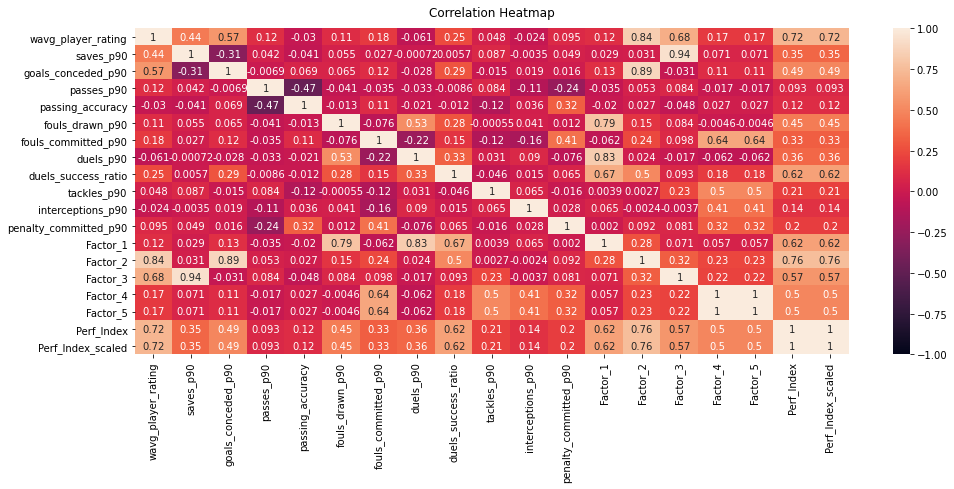

In [32]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_perf_idx.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [33]:
dict_weights['Goalkeepers'] = df_factors_gk['PC_Weight'].dropna().to_dict()

NameError: name 'dict_weights' is not defined

In [ ]:
dict_weights

## Analisis LatAm

In [6]:
import sys
import joblib
PATH_REPO = 'C:/Repo/MiM_Analytics_Tesis/Tesis/performance_index/'
sys.path.insert(0, PATH_REPO)
import PI_Preprocessing

In [7]:
dict_perf_index = joblib.load(PATH_REPO+'PerformanceIndexObject.pkl')
df_all = pd.read_csv(path+'AR_All_20211026.csv', sep='|', decimal='.')

In [8]:
player_cols = dict_perf_index['cols']['player_cols']

In [9]:
# Preprocessing
df = PI_Preprocessing.filter_and_data_engineering(df_all, rating_correction=None, correct_rating=False)

In [10]:
len(df[['league_season', 'player_id', 'team_id']].drop_duplicates())/len(df)

1.0

In [11]:
player_cols = ['team_country_code', 'team_country', 'league_id', 'league_name','league_type', 'league_season', 
               'player_id', 'player_name', 'player_preferred_position', 'player_preferred_number', 'team_id', 
               'team_name', 'player_minutes', 'wavg_player_rating']

In [12]:
df_indexes = pd.DataFrame()

for position in ['F', 'M', 'D', 'G']:
    
    # Filter and Scale
    df_index = df[df['player_preferred_position']==position].reset_index(drop=True)
    df_index = pd.DataFrame(dict_perf_index['scalers'][position].transform(df_index[dict_perf_index['cols'][position]]))
    df_index.columns = dict_perf_index['cols'][position]
    
    # Calculate Performance Index
    for id_factor in dict_perf_index['index_weights'][position].keys():
        if id_factor != 'Weights':
            df_index[id_factor] = np.sum(df_index[dict_perf_index['cols'][position]]*dict_perf_index['index_weights'][position][id_factor], axis=1)
        else:
            df_index['Perf_Index'] = np.sum(df_index[dict_perf_index['cols'][position]]*dict_perf_index['index_weights'][position][id_factor], axis=1)
        
    df_index['Perf_Index_scaled'] = dict_perf_index['index_weights']['index_scaler'].transform(pd.DataFrame(df_index['Perf_Index']))
    
    # Append results
    df_indexes = df_indexes.append(pd.concat([df[df['player_preferred_position']==position].reset_index(drop=True), 
                                              df_index['Perf_Index_scaled']], axis=1)).reset_index(drop=True)

In [14]:
df_indexes[df_indexes['player_preferred_position']=='F'].sort_values('Perf_Index_scaled', ascending=False)

,Unnamed: 0,team_country_code,team_country,league_id,league_name,league_type,league_season,player_id,player_name,player_preferred_position,player_preferred_number,team_id,team_name,player_minutes,wavg_player_rating,offsides,shots_total,shots_on_goal,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_completed,tackles_total,tackles_blocks,tackles_interceptions,tackles_total_padj,tackles_blocks_padj,tackles_interceptions_padj,duels_total,duels_won,dribbles_attemps,dribbles_success,dribbles_past,dribbles_past_padj,fouls_drawn,fouls_committed,fouls_committed_padj,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,offsides_p90,shots_p90,shooting_accuracy,goals_p90,np_goals_p90,goal_conversion,goal_conversion_np,assists_p90,penalty_won_p90,penalty_missed_p90,passes_p90,passing_accuracy,key_passes_p90,fouls_drawn_p90,tackles_p90,blocks_p90,interceptions_p90,total_tackles_p90,saves_p90,penalty_saves_p90,penalty_committed_p90,goals_conceded_p90,fouls_committed_p90,duels_p90,duels_success_ratio,dribbles_p90,dribbles_success_ratio,dribbles_past_p90,cards_yellow_p90,cards_red_p90,scoring_contribution,Perf_Index_scaled
154,1081,AR,Argentina,128,Primera Division,League,2017,5979,Ramon Abila,F,9,451,Boca Juniors,537,7.43,0,15,8,6,0,3,0,79,8,48.56,1,0,1,0.85,0.00,0.96,52,27,9,6,3,2.59,12,5,4.22,1,0,0,0,0,0,0,0.00,2.51,0.53,1.01,1.01,0.40,0.40,0.50,0.00,0.00,13.24,0.61,1.34,2.01,0.14,0.00,0.16,0.30,0.00,0.00,-0.00,-0.00,-0.71,8.72,0.52,1.51,0.67,-0.50,0.17,0.00,1.51,1.11
397,2821,AR,Argentina,128,Primera Division,League,2019,6098,Francisco Pizzini,F,29,442,Defensa Y Justicia,303,7.46,1,6,3,1,0,3,0,62,7,42.26,4,0,0,3.88,0.00,0.00,0,0,11,10,6,5.57,8,3,2.90,0,0,1,0,0,0,0,0.30,1.78,0.50,0.30,0.30,0.17,0.17,0.89,0.30,0.00,18.42,0.68,2.08,2.38,1.15,0.00,0.00,1.15,0.00,0.00,-0.00,-0.00,-0.86,0.00,0.00,3.27,0.91,-1.78,0.00,0.00,1.19,1.09
298,2094,AR,Argentina,128,Primera Division,League,2018,6252,Sebastian Palacios,F,34,456,Talleres Cordoba,362,7.18,0,16,9,3,0,2,0,57,9,37.25,5,0,1,5.44,0.00,0.89,55,23,17,8,5,4.52,7,6,5.58,0,1,0,0,0,0,0,0.00,3.98,0.56,0.75,0.75,0.19,0.19,0.50,0.00,0.00,14.17,0.65,2.24,1.74,1.35,0.00,0.22,1.58,0.00,0.00,-0.00,-0.00,-1.39,13.67,0.42,4.23,0.47,-1.24,0.00,0.25,1.24,1.09
893,7725,BR,Brazil,71,Serie A,League,2020,195090,Peglow,F,31,119,Internacional,347,6.86,0,6,4,2,0,3,0,106,11,21.17,6,0,2,5.59,0.00,2.56,62,20,12,5,5,5.16,4,14,16.30,1,0,0,0,0,0,0,0.00,1.56,0.67,0.52,0.52,0.33,0.33,0.78,0.00,0.00,27.49,0.20,2.85,1.04,1.45,0.00,0.66,2.11,0.00,0.00,-0.00,-0.00,-4.23,16.08,0.32,3.11,0.42,-1.30,0.26,0.00,1.30,1.09
1276,10358,CO,Colombia,239,Primera A,League,2017,13488,Wilfrido De la Rosa,F,24,1126,Deportivo Pasto,500,7.12,0,14,9,6,0,0,0,66,3,45.85,0,0,0,0.00,0.00,0.00,45,13,1,1,0,0.00,11,17,15.93,2,0,0,0,0,0,0,0.00,2.52,0.64,1.08,1.08,0.43,0.43,0.00,0.00,0.00,11.88,0.69,0.54,1.98,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-2.87,8.10,0.29,0.18,1.00,-0.00,0.36,0.00,1.08,1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,679,AR,Argentina,128,Primera Division,League,2016,50320,Jaime Ayovi,F,11,439,Godoy Cruz,520,NaN,0,12,4,1,10,0,0,0,0,0.00,3,1,1,2.60,0.91,0.78,0,0,0,0,0,0.00,4,6,5.17,0,0,0,0,0,0,0,0.00,2.08,0.33,0.17,0.17,0.08,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.45,0.17,0.14,0.76,0.00,0.00,-0.00,-1.73,-0.90,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.17,0.19
22,146,AR,Argentina,128,Primera Division,League,2016,5652,Marco Borgnino,F,23,465,Atletico DE Rafaela,376,6.30,0,4,1,0,5,0,0,7,0,4.71,2,1,3,2.70,1.00,3.43,9,3,0,0,1,1.04,9,6,6.98,1,0,0,0,0,0,0,0.00,0.96,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.68,0.67,0.00,2.15,0.65,0.24,0.82,1.71,0.00,0.00,-0.00,-1.20,-1.67,2.15,0.33,0.00,0.00

In [15]:
df_player = df_indexes[df_indexes['player_name'] == 'Ignacio Scocco']

In [16]:
df_player

,Unnamed: 0,team_country_code,team_country,league_id,league_name,league_type,league_season,player_id,player_name,player_preferred_position,player_preferred_number,team_id,team_name,player_minutes,wavg_player_rating,offsides,shots_total,shots_on_goal,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_completed,tackles_total,tackles_blocks,tackles_interceptions,tackles_total_padj,tackles_blocks_padj,tackles_interceptions_padj,duels_total,duels_won,dribbles_attemps,dribbles_success,dribbles_past,dribbles_past_padj,fouls_drawn,fouls_committed,fouls_committed_padj,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,offsides_p90,shots_p90,shooting_accuracy,goals_p90,np_goals_p90,goal_conversion,goal_conversion_np,assists_p90,penalty_won_p90,penalty_missed_p90,passes_p90,passing_accuracy,key_passes_p90,fouls_drawn_p90,tackles_p90,blocks_p90,interceptions_p90,total_tackles_p90,saves_p90,penalty_saves_p90,penalty_committed_p90,goals_conceded_p90,fouls_committed_p90,duels_p90,duels_success_ratio,dribbles_p90,dribbles_success_ratio,dribbles_past_p90,cards_yellow_p90,cards_red_p90,scoring_contribution,Perf_Index_scaled
35,242,AR,Argentina,128,Primera Division,League,2016,6015,Ignacio Scocco,F,32,457,Newells Old Boys,1672,6.99,0,47,16,8,5,4,0,247,17,183.67,6,1,3,7.06,1.19,3.08,132,49,34,11,6,5.71,29,14,13.47,4,0,0,0,2,1,0,0.00,2.53,0.34,0.43,0.32,0.17,0.13,0.22,0.00,0.05,13.30,0.74,0.92,1.56,0.38,0.05,0.17,0.60,0.00,0.00,-0.00,-0.27,-0.73,7.11,0.37,1.83,0.32,-0.32,0.22,0.00,0.54,0.60
160,1105,AR,Argentina,128,Primera Division,League,2017,6015,Ignacio Scocco,F,32,435,River Plate,1553,7.03,0,57,25,10,0,0,0,304,24,216.17,3,0,3,2.66,0.00,2.43,206,85,54,32,20,17.59,28,26,21.93,4,0,0,0,3,0,0,0.00,3.30,0.44,0.58,0.41,0.18,0.12,0.00,0.00,0.00,17.62,0.71,1.39,1.62,0.15,0.00,0.14,0.30,0.00,0.00,-0.00,-0.00,-1.27,11.94,0.41,3.13,0.59,-1.16,0.23,0.00,0.41,0.74
273,1912,AR,Argentina,128,Primera Division,League,2018,6015,Ignacio Scocco,F,32,435,River Plate,405,6.95,0,14,7,3,0,0,0,79,2,56.81,5,0,0,4.84,0.00,0.00,56,20,12,3,4,3.64,5,6,5.39,1,0,0,0,1,0,0,0.00,3.11,0.50,0.67,0.44,0.21,0.14,0.00,0.00,0.00,17.56,0.72,0.44,1.11,1.08,0.00,0.00,1.08,0.00,0.00,-0.00,-0.00,-1.20,12.44,0.36,2.67,0.25,-0.89,0.22,0.00,0.44,0.61
388,2764,AR,Argentina,128,Primera Division,League,2019,6015,Ignacio Scocco,F,32,435,River Plate,628,7.21,0,23,11,6,1,1,0,127,9,80.05,7,2,0,6.85,1.94,0.00,0,0,24,13,6,5.44,13,11,10.45,3,0,0,0,0,0,0,0.00,3.30,0.48,0.86,0.86,0.26,0.26,0.14,0.00,0.00,18.20,0.63,1.29,1.86,0.98,0.29,0.00,1.27,0.00,0.00,-0.00,-0.14,-1.50,0.00,0.00,3.44,0.54,-0.86,0.43,0.00,1.00,0.96
477,3483,AR,Argentina,128,Primera Division,League,2020,6015,Ignacio Scocco,F,32,457,Newells Old Boys,315,6.79,0,5,4,1,0,0,0,72,4,1.61,2,0,2,2.08,0.00,2.70,29,11,6,2,6,8.15,5,1,0.89,1,0,0,0,0,0,0,0.00,1.43,0.80,0.29,0.29,0.20,0.20,0.00,0.00,0.00,20.57,0.02,1.14,1.43,0.60,0.00,0.77,1.37,0.00,0.00,-0.00,-0.00,-0.26,8.29,0.38,1.71,0.33,-1.71,0.29,0.00,0.29,0.60


In [17]:
df_player.columns

Index(['Unnamed: 0', 'team_country_code', 'team_country', 'league_id',
       'league_name', 'league_type', 'league_season', 'player_id',
       'player_name', 'player_preferred_position', 'player_preferred_number',
       'team_id', 'team_name', 'player_minutes', 'wavg_player_rating',
       'offsides', 'shots_total', 'shots_on_goal', 'goals_total',
       'goals_conceded', 'goals_assists', 'goals_saves', 'passes_total',
       'passes_key', 'passes_completed', 'tackles_total', 'tackles_blocks',
       'tackles_interceptions', 'tackles_total_padj', 'tackles_blocks_padj',
       'tackles_interceptions_padj', 'duels_total', 'duels_won',
       'dribbles_attemps', 'dribbles_success', 'dribbles_past',
       'dribbles_past_padj', 'fouls_drawn', 'fouls_committed',
       'fouls_committed_padj', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_committed', 'penalty_scored', 'penalty_missed',
       'penalty_saved', 'offsides_p90', 'shots_p90', 'shooting_accuracy',
       'goals_p9

In [36]:
player_cols = ['player_id', 'player_name']
stats_season = ['player_preferred_position', 'player_preferred_number', 'player_minutes', 'wavg_player_rating', 
                'goals_total', 'goals_assists']
attack = ['scoring_contribution', 'goals_p90', 'shots_p90', 'shooting_accuracy', 'goal_conversion', 'assists_p90']
build_up = ['passes_p90', 'passing_accuracy', 'key_passes_p90', 'duels_p90', 'duels_success_ratio', 'dribbles_p90', 
            'dribbles_success_ratio']
defense = ['tackles_p90', 'blocks_p90', 'interceptions_p90', 'saves_p90', 'fouls_committed_p90', 'fouls_drawn_p90', 
           'cards_yellow', 'cards_red']

In [30]:
current_season = 2020
df_player[df_player['league_season'] == current_season][stats_season].transpose()

,477
player_preferred_position,F
player_preferred_number,32
player_minutes,315
wavg_player_rating,6.79
goals_total,1
goals_assists,0


In [31]:
df_player[df_player['league_season'] == current_season][attack].transpose()

,477
scoring_contribution,0.29
goals_p90,0.29
shots_p90,1.43
shooting_accuracy,0.80
goal_conversion,0.20
assists_p90,0.00


In [32]:
df_player[df_player['league_season'] == current_season][build_up].transpose()

,477
passes_p90,20.57
passing_accuracy,0.02
key_passes_p90,1.14
duels_p90,8.29
duels_success_ratio,0.38
dribbles_p90,1.71
dribbles_success_ratio,0.33


In [40]:
df_player[df_player['league_season'] == current_season][defense].transpose().reset_index()

In [47]:
df_prueba = df_player[df_player['league_season'] == current_season][stats_season].transpose().reset_index()

In [42]:
df_prueba['Cols'] = df_prueba['index'].map(dict_cols['ColumnNames'])

In [53]:
df_prueba.loc[df_prueba['index']=='player_preferred_position', 477].map(dict_col['player_preferred_position'])

0    Delantero
Name: 477, dtype: object

In [44]:
dict_col= {"player_preferred_position":  {"F": "Delantero", "M": "Mediocampista", "D": "Defensor", "G": "Arquero"}}